# RNA-seq workflow: gene-level exploratory analysis and differential expression


Here we reproduces in SoS analysis originally performed by [`rnaseqGene`](https://www.bioconductor.org/help/workflows/rnaseqGene/#introduction) Bioconductor workflow,  authored by:

**Michael I. Love<sup>1</sup>, Simon Anders<sup>2,3</sup>, Vladislav Kim<sup>3</sup> and Wolfgang Huber<sup>3</sup>**

<sup>1</sup>Departments of Biostatistics and Genetics, UNC-Chapel Hill, Chapel Hill, NC, US
<sup>2</sup>Institute for Molecular Medicine Finland (FIMM), Helsinki, Finland
<sup>3</sup>European Molecular Biology Laboratory (EMBL), Heidelberg, Germany

This notebook is converted from [a Jupyter implementation](https://github.com/Bioconductor-notebooks/Dynamic-Re-analysis-RNA-seq-differential-expression-workflow). See [this paper](http://dx.doi.org/10.1101/144816) for more details. The original Bioconductor workflow loads pre-processed BAM files packaged into `airway` library, and perform interactive analysis along the way. Here we highlight the advantage using SoS over a conventional Jupyter `R` notebook: 

* All command-line based procedures can be formally implemented in SoS and performed in an interactive environment.
* This notebook configures the cell tags for `sos report` style of HTML output. When exported using that style, only important codes and results will be displayed. This improves workflow readability.
* All figures are created in PDF format to the proper destination directory, and previewed as embedded image via SoS. With this feature users no longer have to write separated codes for interactive figure display and actually obtaining the high-resolution version of the plots in PDF format.

It also demonstrates how SoS handles command tool and R library dependencies automatically. Since most command-line tools involved are available on [Docker Hub](https://hub.docker.com) SoS utilizes these images, this workflow requires [Docker](https://docs.docker.com/engine/installation/) be installed and configured (although alternatively one also install individual tools using SoS auxillary steps).

In [1]:
%cd ~/GIT/LargeFiles/RNAseqDE

/home/gaow/GIT/LargeFiles/RNAseqDE

In [2]:
[global]
parameter: cwd = path('~/GIT/LargeFiles/RNAseqDE')
parameter: samples = ['SRR1039508', 'SRR1039509', 'SRR1039512', 'SRR1039513', 'SRR1039516', 'SRR1039517', 'SRR1039520', 'SRR1039521']
parameter: ncpu = 4
# Resource files
resource_dir = f"{cwd:a}/hg19"
ref_fa = "hg19.fa"
ref_gtf = 'Homo_sapiens.GRCh38.91.gtf.gz'
# when set to False (default) STAR will use ~30GB memory.
# set it to `True` to reduce memory consumption to half.
parameter: sparse_star = False

Please note that here we have specified paths to pre-existing directories in the `[global]` section, with `parameter` keyword. This setup allows users to configure all paths in one places for a “default” run, and optionally can configure them from command-line or `%sosrun` magic. To elaborate, for example:

```
[global]
parameter: cwd = path('~/GIT/LargeFiles/RNAseqDE')
```

can be override by command argument `--cwd /path/to/new/dir`. An alternative implementation is to use configuration file, eg, create a file called `config.yml` and write:

```
cwd: path('~/GIT/LargeFiles/RNAseqDE')
```
and execute with `%sosrun -c config.yml`. The downside is that a `config.yml` file will have to be maintained.

## Abstract

Here we walk through an end-to-end gene-level RNA-seq differential expression workflow using Bioconductor packages and other tools in [SoS](http://vatlab.github.io/sos) scripting environment. We will start from the FASTQ files, show how these were aligned to the reference genome, and prepare a count matrix which tallies the number of RNA-seq reads/fragments within each gene for each sample. We will perform exploratory data analysis (EDA) for quality assessment and to explore the relationship between samples, perform differential gene expression analysis, and visually explore the results.


## Experimental data

The data used in this workflow is stored in the [airway](http://bioconductor.org/packages/airway) package that summarizes an RNA-seq experiment wherein airway smooth muscle cells were treated with dexamethasone, a synthetic glucocorticoid steroid with anti-inflammatory effects (Himes et al. 2014). Glucocorticoids are used, for example, by people with asthma to reduce inflammation of the airways. In the experiment, four primary human airway smooth muscle cell lines were treated with 1 micromolar dexamethasone for 18 hours. For each of the four cell lines, we have a treated and an untreated sample. For more description of the experiment see the [PubMed entry 24926665](http://www.ncbi.nlm.nih.gov/pubmed/24926665) and for raw data see the [GEO entry GSE52778](http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE52778).

## Preparing Count Matrices

As input, the count-based statistical methods, such as [`DESeq2`](http://bioconductor.org/packages/DESeq2) (Love, Huber, and Anders 2014), [`edgeR`](http://bioconductor.org/packages/edgeR) (M. D. Robinson, McCarthy, and Smyth 2009), [`limma`](http://bioconductor.org/packages/limma) with the voom method (Law et al. 2014), [`DSS`](http://bioconductor.org/packages/DSS) (H. Wu, Wang, and Wu 2013), [`EBSeq`](http://bioconductor.org/packages/EBSeq) (Leng et al. 2013) and [`baySeq`](http://bioconductor.org/packages/baySeq) (Hardcastle and Kelly 2010), expect input data as obtained, e.g., from RNA-seq or another high-throughput sequencing experiment, in the form of a matrix of integer values. The value in the $i$-th row and the $j$-th column of the matrix tells how many reads (or fragments, for paired-end RNA-seq) have been assigned to gene $i$ in sample $j$. Analogously, for other types of assays, the rows of the matrix might correspond e.g., to binding regions (with ChIP-Seq), species of bacteria (with metagenomic datasets), or peptide sequences (with quantitative mass spectrometry).

The values in the matrix should be counts of sequencing reads/fragments. This is important for `DESeq2`’s statistical model to hold, as only counts allow assessing the measurement precision correctly. It is important to never provide counts that were pre-normalized for sequencing depth/library size, as the statistical model is most powerful when applied to un-normalized counts, and is designed to account for library size differences internally.

### Recommended: transcript abundances and the tximport pipeline

Before we demonstrate how to align and then count RNA-seq fragments, we mention that a newer and faster alternative pipeline is to use transcript abundance quantification methods such as [`Salmon`](https://combine-lab.github.io/salmon/) (Patro et al. 2016), [`Sailfish`](http://www.cs.cmu.edu/~ckingsf/software/sailfish/) (Patro, Mount, and Kingsford 2014), [`kallisto`](https://pachterlab.github.io/kallisto/) (Bray et al. 2016), or [`RSEM`](http://deweylab.github.io/RSEM/) (B. Li and Dewey 2011), to estimate abundances without aligning reads, followed by the [`tximport`](http://bioconductor.org/packages/tximport) package for assembling estimated count and offset matrices for use with Bioconductor differential gene expression packages.

A tutorial on how to use the Salmon software for quantifying transcript abundance can be found [here](https://combine-lab.github.io/salmon/getting_started/). Following that tutorial, you can use the steps in the [`tximport` vignette](https://bioconductor.org/packages/release/bioc/vignettes/tximport/inst/doc/tximport.html), which will show how to build a DESeqDataSet. This is our current recommended pipeline for users, but below we still include steps on aligning reads to the genome and building count matrices from BAM files.

The advantages of using the transcript abundance quantifiers in conjunction with tximport to produce gene-level count matrices and normalizing offsets, are: this approach corrects for any potential changes in gene length across samples (e.g. from differential isoform usage) (Trapnell et al. 2013); some of these methods are substantially faster and require less memory and disk usage compared to alignment-based methods; and it is possible to avoid discarding those fragments that can align to multiple genes with homologous sequence (Robert and Watson 2015). Note that transcript abundance quantifiers skip the generation of large files which store read alignments, instead producing smaller files which store estimated abundances, counts, and effective lengths per transcript. For more details, see the manuscript describing this approach (Soneson, Love, and Robinson 2015), and the [`tximport`](http://bioconductor.org/packages/tximport) package vignette for software details. The entry point back into this workflow after using a transcript quantifier and tximport would be the section on exploratory data analysis below.

### Aligning read to a reference genome

The computational analysis of an RNA-seq experiment begins from the FASTQ files that contain the nucleotide sequence of each read and a quality score at each position. These reads must first be aligned to a reference genome or transcriptome, or the abundances and estimated counts per transcript can be estimated without alignment, as described above. In either case, it is important to know if the sequencing experiment was single-end or paired-end, as the alignment software will require the user to specify both FASTQ files for a paired-end experiment. The output of this alignment step is commonly stored in a file format called [SAM/BAM](http://samtools.github.io/hts-specs).

A number of software programs exist to align reads to a reference genome, and we encourage you to check out some of the benchmarking papers that discuss the advantages and disadvantages of each software, which include accuracy, sensitivity in aligning reads over splice junctions, speed, memory required, usability, and many other features. Here, we used the [`STAR read aligner`](https://code.google.com/p/rna-star/) (Dobin et al. 2013) to align the reads for our current experiment to the Ensembl release 75 (Flicek et al. 2014) human reference genome. In the following code example, it is assumed that there is a file in the current directory called `files` with each line containing an identifier for each experiment, and we have all the FASTQ files in a subdirectory `fastq`. If you have downloaded the FASTQ files from the Sequence Read Archive, the identifiers would be SRA run IDs, e.g. `SRR1039520`. You should have two files for a paired-end experiment for each ID, `fastq/SRR1039520_1.fastq` and `fastq/SRR1039520_2.fastq`, which give the first and second read for the paired-end fragments. If you have performed a single-end experiment, you would only have one file per ID. We have also created a subdirectory, `aligned`, where `STAR` will output its alignment files.

#### Download and decrypt  SRA files

This is an auxiliary step that gets `fastq` files for input to STAR aligner

In [2]:
# decrypt SRA files
[sra (dump SRA to fastq): provides=['{data}_1.fastq', '{data}_2.fastq']]
depends: Py_Module('docker')
output: f'{data}_1.fastq', f'{data}_2.fastq'
run: docker_image = 'gaow/debian-ngs', workdir = cwd, expand=True
    fastq-dump -I --split-files {os.path.basename(data)}

#### Prepare STAR reference genome

In [1]:
# Download `hg19.2bit` and `twoBitToFa` from UCSC
[hg19_reference_1 (download)]
ucsc_url = "http://hgdownload.cse.ucsc.edu"
output: f"{resource_dir}/hg19.2bit", f"{resource_dir}/twoBitToFa"
download: dest_dir = resource_dir, expand = True
    {ucsc_url}/goldenPath/hg19/bigZips/hg19.2bit
    {ucsc_url}/admin/exe/{"macOSX.x86_64" if sys.platform == 'darwin' else "linux.x86_64"}/twoBitToFa

# Use `twoBitToFa` to extract `hg19.fa` from `hg19.2bit`
[hg19_reference_2 (decompress hg19.fa)]
output: f"{resource_dir}/{ref_fa}"
bash: expand = True
    chmod +x {_input[1]}
    {_input[1]} {_input[0]} {_output}

# Download `Homo_sapiens.GRCh38.91.gtf.gz` from Ensembl
[hg19_reference_3 (gene annotations)]
# https://useast.ensembl.org/info/data/ftp/index.html
ensembl_ftp = 'ftp://ftp.ensembl.org/pub/release-91/gtf/homo_sapiens/'
output: f"{resource_dir}/{ref_gtf}"
download: dest_dir = resource_dir, expand = True
    {ensembl_ftp}/{ref_gtf}
    
# Prepare STAR reference data
[star: provides = f"{resource_dir}/genomeParameters.txt"]
# Quite time & resource consuming (3hrs, 32GB memory if sparse_star is False)
depends: Py_Module('docker'), sos_step('hg19_reference')
output: f"{resource_dir}/genomeParameters.txt"
run: workdir = '/tmp', docker_image = 'gaow/debian-ngs', volumes = [f'{resource_dir}:{resource_dir}'], expand=True
     STAR --runMode genomeGenerate \
        --genomeDir {resource_dir} \
        --genomeFastaFiles {resource_dir}/{ref_fa} \
        --sjdbGTFtagExonParentTranscript {resource_dir}/{ref_gtf} \
        --runThreadN {ncpu} {'--genomeSAsparseD 2' if sparse_star else ''}

#### Alignment via STAR

This step is memory intensive (32GB memory required per sample).

In [5]:
# Align to SAM file
[align_1 (STAR alignment)]
depends: Py_Module('docker'), f"{resource_dir}/genomeParameters.txt"
input: [(f'{cwd:a}/{s}_1.fastq', f'{cwd:a}/{s}_2.fastq') for s in samples], group_by = "pairs", concurrent = True
output: [f"{cwd:a}/{s}.Aligned.out.sam" for s in samples], group_by = 1
run: docker_image = 'gaow/debian-ngs', volumes = [f'{resource_dir}:{resource_dir}'], expand=True, workdir = cwd
    STAR --genomeDir {resource_dir} \
        --readFilesIn {_input[0]} {_input[1]} \
        --runThreadN {ncpu} --outFileNamePrefix {_output:nnn}.

#### Generate BAM files

In [6]:
# Convert SAM to BAM file & zap the input
[align_2 (SAM to BAM)]
depends: Py_Module('docker')
input: group_by = 1, pattern = '{name}.Aligned.out.sam', concurrent = True
output: expand_pattern('{_name}.bam')
run: docker_image = 'gaow/debian-ngs', expand=True, workdir = cwd
    samtools view -bS {_input} -o {_output}
_input.zap()

The BAM files for a number of sequencing runs can then be used to generate count matrices, as described in the following section.

Notice that the `align_2` step can be avoided if in `align_1` step options `--outStd BAM_SortedByCoordinate  --outSAMtype BAM SortedByCoordinate` are used for `STAR` aligner. We do not use those options because we would like to follow exactly how the Bioconductor tutorial instructs, for demonstration purpose. However we used `_input.zap()` at the end of the step to delete those SAM files without potentially triggering reruns.

#### Run the alignment pipeline

The following executes the pipeline from inside this notebook using 2 CPU cores in parallel:

In [ ]:
%sosrun align -j 2

Or, to run it from command console:

```
sos run RNASeqDE.ipynb align -j 2
```

Caution that large data-set will be downloaded at a result of this alignment workflow and the alignment process is computationally intensive. Also `align_1` STAR step uses ~ 30GB memory so `-j 2` is used on a machine with 64GB of memory. This workflow will not impact the rest of demonstrations to follow; readers can terminate the workflow at any time they deem fit.

**If the goal is to test the workflow please only run it with one sample to avoid too much computation, eg:**

```
sos run RNASeqDE.ipynb align --samples SRR1039508
```

### Locating alignment files

In the previous section we have shown the RNA-seq alignment via the `align` workflow, from downloading the SRA files and the tools (in Docker) needed, to generating BAM files. Here, for demonstration, we chose a subset of reads because the full alignment files are large (a few gigabytes each), and because it takes between 10-30 minutes to count the fragments for each sample. These files are provided as part of the `airway` library. We will use these files to demonstrate how a count matrix can be constructed from BAM files. Afterwards, we will load the full count matrix corresponding to all samples and all data, which is already provided in the same package, and will continue the analysis with that full matrix.

We check via SoS if the required packages are available for the rest of the workflow to run, and install it otherwise:


In [7]:
depends: R_library('airway'), R_library('Rsamtools'), R_library('GenomicFeatures'),
    R_library('GenomicAlignments'), R_library('BiocParallel'), R_library('DESeq2'), 
    R_library("vsn"), R_library('pheatmap'), R_library('ggplot2'), R_library("PoiClaClu"), 
    R_library('ggbeeswarm'), R_library('genefilter'), R_library("AnnotationDbi"), 
    R_library("org.Hs.eg.db"), R_library("ReportingTools"),
    R_library("Gviz"), R_library("sva"), R_library('fission')

Now we are ready to explore the alignment data.

In [7]:
suppressPackageStartupMessages(library("airway"))
indir <- system.file("extdata", package="airway", mustWork=TRUE)
print("List of Files in the /extdata directory of the airway package:")
list.files(indir)

[1] "List of Files in the /extdata directory of the airway package:"


[1] "GSE52778_series_matrix.txt"        "Homo_sapiens.GRCh37.75_subset.gtf"
 [3] "sample_table.csv"                  "SraRunInfo_SRP033351.csv"         
 [5] "SRR1039508_subset.bam"             "SRR1039509_subset.bam"            
 [7] "SRR1039512_subset.bam"             "SRR1039513_subset.bam"            
 [9] "SRR1039516_subset.bam"             "SRR1039517_subset.bam"            
[11] "SRR1039520_subset.bam"             "SRR1039521_subset.bam"

Typically, we have a table with detailed information for each of our samples that links samples to the associated FASTQ and BAM files. For your own project, you might create such a comma-separated value (CSV) file using a text editor or spreadsheet software such as Excel.
We load such a CSV file with read.csv:

In [8]:
csvfile <- file.path(indir, "sample_table.csv")
sampleTable <- read.csv(csvfile, row.names = 1)
sampleTable

,SampleName,cell,dex,albut,Run,avgLength,Experiment,Sample,BioSample
SRR1039508,GSM1275862,N61311,untrt,untrt,SRR1039508,126,SRX384345,SRS508568,SAMN02422669
SRR1039509,GSM1275863,N61311,trt,untrt,SRR1039509,126,SRX384346,SRS508567,SAMN02422675
SRR1039512,GSM1275866,N052611,untrt,untrt,SRR1039512,126,SRX384349,SRS508571,SAMN02422678
SRR1039513,GSM1275867,N052611,trt,untrt,SRR1039513,87,SRX384350,SRS508572,SAMN02422670
SRR1039516,GSM1275870,N080611,untrt,untrt,SRR1039516,120,SRX384353,SRS508575,SAMN02422682
SRR1039517,GSM1275871,N080611,trt,untrt,SRR1039517,126,SRX384354,SRS508576,SAMN02422673
SRR1039520,GSM1275874,N061011,untrt,untrt,SRR1039520,101,SRX384357,SRS508579,SAMN02422683
SRR1039521,GSM1275875,N061011,trt,untrt,SRR1039521,98,SRX384358,SRS508580,SAMN02422677


Once the reads have been aligned, there are a number of tools that can be used to count the number of reads/fragments that can be assigned to genomic features for each sample. These often take as input SAM/BAM alignment files and a file specifying the genomic features, e.g. a GFF3 or GTF file specifying the gene models.

In [9]:
## Checking for the existance of files in the package directory.
filenames <- file.path(indir, paste0(sampleTable$Run, "_subset.bam"))
unique(sampleTable$Run)
file.exists(filenames)

[1] SRR1039508 SRR1039509 SRR1039512 SRR1039513 SRR1039516 SRR1039517 SRR1039520
[8] SRR1039521
8 Levels: SRR1039508 SRR1039509 SRR1039512 SRR1039513 ... SRR1039521

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

#### DESeq2 import functions

The following tools can be used generate count matrices: summarizeOverlaps (Lawrence et al. 2013), featureCounts (Liao, Smyth, and Shi 2014), tximport (Soneson, Love, and Robinson 2015), htseq-count (Anders, Pyl, and Huber 2015).


| **function** | **package** | **framework** | **output** | **DESeq2 input function** |
|---|---|---|---|---|
| summarizeOverlaps | GenomicAlignments | R/Bioconductor | SummarizedExperiment | DESeqDataSet |
| featureCounts | Rsubread | R/Bioconductor | matrix | DESeqDataSetFromMatrix |
| tximport | tximport | R/Bioconductor | list of matrices | DESeqDataSetFromTximport |
| htseq-count | HTSeq | Python | files | DESeqDataSetFromHTSeq |

We now proceed using summarizeOverlaps. Using the Run column in the sample table, we construct the full paths to the files we want to perform the counting operation on.

In [10]:
## Bam files list from the Rsamtools[3] package
suppressPackageStartupMessages(library("Rsamtools"))
bamfiles <- BamFileList(filenames, yieldSize=2000000)

**Note:** 
Make sure that the chromosome names of the genomic features in the annotation you use are consistent with the chromosome names of the reference used for read alignment. Otherwise, the scripts might fail to count any reads to features due to the mismatching names. For example, a common mistake is when the alignment files contain chromosome names in the style of 1 and the gene annotation in the style of chr1, or the other way around. See the seqlevelsStyle function in the GenomeInfoDb package for solutions. We can check the chromosome names (here called "seqnames") in the alignment files:

In [11]:
## The sequence Info
seqinfo(bamfiles[1])

Seqinfo object with 84 sequences from an unspecified genome:
  seqnames   seqlengths isCircular genome
  1           249250621       <NA>   <NA>
  10          135534747       <NA>   <NA>
  11          135006516       <NA>   <NA>
  12          133851895       <NA>   <NA>
  13          115169878       <NA>   <NA>
  ...               ...        ...    ...
  GL000210.1      27682       <NA>   <NA>
  GL000231.1      27386       <NA>   <NA>
  GL000229.1      19913       <NA>   <NA>
  GL000226.1      15008       <NA>   <NA>
  GL000207.1       4262       <NA>   <NA>

## Defining gene models

Next, we need to read in the gene model that will be used for counting reads/fragments. We will read the gene model from an Ensembl GTF file (Flicek et al. 2014), using makeTxDbFromGFF from the `GenomicFeatures` package. GTF files can be downloaded from Ensembl’s FTP site or other gene model repositories. A TxDb object is a database that can be used to generate a variety of range-based objects, such as exons, transcripts, and genes. We want to make a list of exons grouped by gene for counting read/fragments.

There are other options for constructing a TxDb. For the known genes track from the UCSC Genome Browser (Kent et al. 2002), one can use the pre-built Transcript DataBase: TxDb.Hsapiens.UCSC.hg19.knownGene. If the annotation file is accessible from AnnotationHub (as is the case for the Ensembl genes), a pre-scanned GTF file can be imported using makeTxDbFromGRanges.

In [12]:
suppressPackageStartupMessages(library("GenomicFeatures"))
## txdb format
gtffile <- file.path(indir,"Homo_sapiens.GRCh37.75_subset.gtf")
txdb <- makeTxDbFromGFF(gtffile, format = "gtf", circ_seqs = character())
txdb

Import genomic features from the file as a GRanges object ...
OK
Prepare the 'metadata' data frame ...
OK
Make the TxDb object ...
OK


TxDb object:
# Db type: TxDb
# Supporting package: GenomicFeatures
# Data source: /home/gaow/R/x86_64-pc-linux-gnu-library/3.3/airway/extdata/Homo_sapiens.GRCh37.75_subset.gtf
# Organism: NA
# Taxonomy ID: NA
# miRBase build ID: NA
# Genome: NA
# transcript_nrow: 65
# exon_nrow: 279
# cds_nrow: 158
# Db created by: GenomicFeatures package from Bioconductor
# Creation time: 2017-09-22 16:08:35 -0500 (Fri, 22 Sep 2017)
# GenomicFeatures version at creation time: 1.28.5
# RSQLite version at creation time: 2.0
# DBSCHEMAVERSION: 1.1

We can produce a GRangesList of all the exons grouped by gene (Lawrence et al. 2013). Each element of the list is a GRanges object of the exons for a gene.

In [13]:
ebg <- exonsBy(txdb, by="gene")
ebg

GRangesList object of length 20:
$ENSG00000009724 
GRanges object with 18 ranges and 2 metadata columns:
       seqnames               ranges strand |   exon_id       exon_name
          <Rle>            <IRanges>  <Rle> | <integer>     <character>
   [1]        1 [11086580, 11087705]      - |        98 ENSE00000818830
   [2]        1 [11090233, 11090307]      - |        99 ENSE00000472123
   [3]        1 [11090805, 11090939]      - |       100 ENSE00000743084
   [4]        1 [11094885, 11094963]      - |       101 ENSE00000743085
   [5]        1 [11097750, 11097868]      - |       102 ENSE00003482788
   ...      ...                  ...    ... .       ...             ...
  [14]        1 [11106948, 11107176]      - |       111 ENSE00003467404
  [15]        1 [11106948, 11107176]      - |       112 ENSE00003489217
  [16]        1 [11107260, 11107280]      - |       113 ENSE00001833377
  [17]        1 [11107260, 11107284]      - |       114 ENSE00001472289
  [18]        1 [11107260, 1110

### Read counting steps

After these preparations, the actual counting is easy. The function summarizeOverlaps from the `GenomicAlignments` package will do this. This produces a SummarizedExperiment object that contains a variety of information about the experiment, and will be described in more detail below.

**Note:** If it is desired to perform counting using multiple cores, one can use the register and MulticoreParam or SnowParam functions from the `BiocParallel` package before the counting call below. Expect that the summarizeOverlaps call will take at least 30 minutes per file for a human RNA-seq file with 30 million aligned reads. By sending the files to separate cores, one can speed up the entire counting process.

In [14]:
suppressPackageStartupMessages(library("GenomicAlignments"))
suppressPackageStartupMessages(library("BiocParallel"))

# register(MulitcoreParam())
register(SerialParam())
se <- summarizeOverlaps(features=ebg, reads=bamfiles,
                        mode="Union",
                        singleEnd=FALSE,
                        ignore.strand=TRUE,
                        fragments=TRUE)

We specify a number of arguments besides the `features` and the `reads`. The `mode` argument describes what kind of read overlaps will be counted. These modes are shown in Figure 1 of the Counting reads with summarizeOverlaps vignette for the `GenomicAlignments` package. Note that fragments will be counted only once to each gene, even if they overlap multiple exons of a gene which may themselves be overlapping. Setting `singleEnd` to `FALSE` indicates that the experiment produced paired-end reads, and we want to count a pair of reads (a fragment) only once toward the count for a gene. The `fragments` argument can be used when `singleEnd=FALSE` to specify if unpaired reads should be counted (yes if `fragments=TRUE`).

In order to produce correct counts, it is important to know if the RNA-seq experiment was strand-specific or not. This experiment was not strand-specific so we set `ignore.strand` to `TRUE`. However, certain strand-specific protocols could have the reads align only to the opposite strand of the genes. The user must check if the experiment was strand-specific and if so, whether the reads should align to the forward or reverse strand of the genes. For various counting/quantifying tools, one specifies counting on the forward or reverse strand in different ways, although this task is currently easiest with htseq-count, featureCounts, or the transcript abundance quantifiers mentioned previously. It is always a good idea to check the column sums of the count matrix (see below) to make sure these totals match the expected of the number of reads or fragments aligning to genes. Additionally, one can visually check the read alignments using a genome visualization tool.

### Summarized experiment

The component parts of a SummarizedExperiment object. The assay (pink block) contains the matrix of counts, the rowRanges (blue block) contains information about the genomic ranges and the colData (green block) contains information about the samples. The highlighted line in each block represents the first row (note that the first row of colData lines up with the first column of the assay).

The SummarizedExperiment container is diagrammed in the Figure below and discussed in the latest Bioconductor paper (Huber et al. 2015). In our case we have created a single matrix named “counts” that contains the fragment counts for each gene and sample, which is stored in assay. It is also possible to store multiple matrices, accessed with assays. The rowRanges for our object is the GRangesList we used for counting (one GRanges of exons for each row of the count matrix). The component parts of the SummarizedExperiment are accessed with an R function of the same name: assay (or assays), rowRanges and colData.

This example code above actually only counted a small subset of fragments from the original experiment. Nevertheless, we can still investigate the resulting SummarizedExperiment by looking at the counts in the assay slot, the phenotypic data about the samples in colData slot (in this case an empty DataFrame), and the data about the genes in the rowRanges slot.

In [15]:
pdf("figures/Summarized_Experiment.pdf")
par(mar=c(0,0,0,0))
plot(1,1,xlim=c(0,100),ylim=c(0,100),bty="n",
     type="n",xlab="",ylab="",xaxt="n",yaxt="n")
polygon(c(45,90,90,45),c(5,5,70,70),col="pink",border=NA)
polygon(c(45,90,90,45),c(68,68,70,70),col="pink3",border=NA)
text(67.5,40,"assay")
text(67.5,35,'e.g. "counts"')
polygon(c(10,40,40,10),c(5,5,70,70),col="skyblue",border=NA)
polygon(c(10,40,40,10),c(68,68,70,70),col="skyblue3",border=NA)
text(25,40,"rowRanges")
polygon(c(45,90,90,45),c(75,75,95,95),col="palegreen",border=NA)
polygon(c(45,47,47,45),c(75,75,95,95),col="palegreen3",border=NA)
text(67.5,85,"colData")
dev.off()

png 
  2

> figures/Summarized_Experiment.pdf (4.2 KiB):

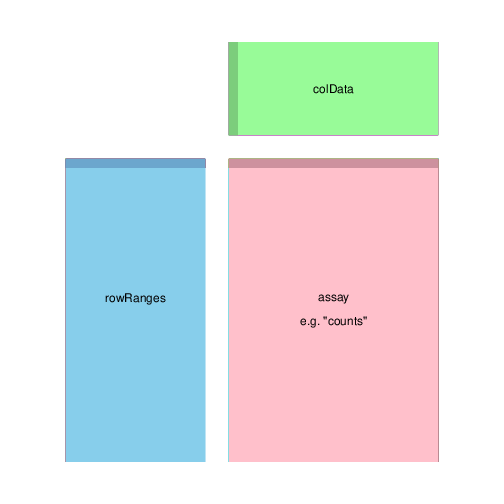

In [16]:
%preview -s png figures/Summarized_Experiment.pdf

Here are various other summary information. These information are by default hidden from display in the HTML file generated by `sos report` template.

In [17]:
se

class: RangedSummarizedExperiment 
dim: 20 8 
metadata(0):
assays(1): counts
rownames(20): ENSG00000009724 ENSG00000116649 ... ENSG00000271794
  ENSG00000271895
rowData names(0):
colnames(8): SRR1039508_subset.bam SRR1039509_subset.bam ...
  SRR1039520_subset.bam SRR1039521_subset.bam
colData names(0):

In [18]:
dim(se)

[1] 20  8

In [19]:
assayNames(se)

[1] "counts"

In [20]:
rowRanges(se)

GRangesList object of length 20:
$ENSG00000009724 
GRanges object with 18 ranges and 2 metadata columns:
       seqnames               ranges strand |   exon_id       exon_name
          <Rle>            <IRanges>  <Rle> | <integer>     <character>
   [1]        1 [11086580, 11087705]      - |        98 ENSE00000818830
   [2]        1 [11090233, 11090307]      - |        99 ENSE00000472123
   [3]        1 [11090805, 11090939]      - |       100 ENSE00000743084
   [4]        1 [11094885, 11094963]      - |       101 ENSE00000743085
   [5]        1 [11097750, 11097868]      - |       102 ENSE00003482788
   ...      ...                  ...    ... .       ...             ...
  [14]        1 [11106948, 11107176]      - |       111 ENSE00003467404
  [15]        1 [11106948, 11107176]      - |       112 ENSE00003489217
  [16]        1 [11107260, 11107280]      - |       113 ENSE00001833377
  [17]        1 [11107260, 11107284]      - |       114 ENSE00001472289
  [18]        1 [11107260, 1110

In [21]:
str(metadata(rowRanges(se)))

List of 1
 $ genomeInfo:List of 15
  ..$ Db type                                 : chr "TxDb"
  ..$ Supporting package                      : chr "GenomicFeatures"
  ..$ Data source                             : chr "/home/gaow/R/x86_64-pc-linux-gnu-library/3.3/airway/extdata/Homo_sapiens.GRCh37.75_subset.gtf"
  ..$ Organism                                : chr NA
  ..$ Taxonomy ID                             : chr NA
  ..$ miRBase build ID                        : chr NA
  ..$ Genome                                  : chr NA
  ..$ transcript_nrow                         : chr "65"
  ..$ exon_nrow                               : chr "279"
  ..$ cds_nrow                                : chr "158"
  ..$ Db created by                           : chr "GenomicFeatures package from Bioconductor"
  ..$ Creation time                           : chr "2017-09-22 16:08:35 -0500 (Fri, 22 Sep 2017)"
  ..$ GenomicFeatures version at creation time: chr "1.28.5"
  ..$ RSQLite version at creation time 

In [22]:
# column Data
colData(se)

DataFrame with 8 rows and 0 columns

In [23]:
head(assay(se), 5)

,SRR1039508_subset.bam,SRR1039509_subset.bam,SRR1039512_subset.bam,SRR1039513_subset.bam,SRR1039516_subset.bam,SRR1039517_subset.bam,SRR1039520_subset.bam,SRR1039521_subset.bam
ENSG00000009724,38,28,66,24,42,41,47,36
ENSG00000116649,1004,1255,1122,1313,1100,1879,745,1536
ENSG00000120942,218,256,233,252,269,465,207,400
ENSG00000120948,2751,2080,3353,1614,3519,3716,2220,1990
ENSG00000171819,4,50,19,543,1,10,14,1067


In [24]:
colSums(assay(se))

SRR1039508_subset.bam SRR1039509_subset.bam SRR1039512_subset.bam 
                 6478                  6501                  7699 
SRR1039513_subset.bam SRR1039516_subset.bam SRR1039517_subset.bam 
                 6801                  8009                 10849 
SRR1039520_subset.bam SRR1039521_subset.bam 
                 5254                  9168

In [25]:
colData(se) <- DataFrame(sampleTable)
colData(se)

DataFrame with 8 rows and 9 columns
           SampleName     cell      dex    albut        Run avgLength
             <factor> <factor> <factor> <factor>   <factor> <integer>
SRR1039508 GSM1275862   N61311    untrt    untrt SRR1039508       126
SRR1039509 GSM1275863   N61311      trt    untrt SRR1039509       126
SRR1039512 GSM1275866  N052611    untrt    untrt SRR1039512       126
SRR1039513 GSM1275867  N052611      trt    untrt SRR1039513        87
SRR1039516 GSM1275870  N080611    untrt    untrt SRR1039516       120
SRR1039517 GSM1275871  N080611      trt    untrt SRR1039517       126
SRR1039520 GSM1275874  N061011    untrt    untrt SRR1039520       101
SRR1039521 GSM1275875  N061011      trt    untrt SRR1039521        98
           Experiment    Sample    BioSample
             <factor>  <factor>     <factor>
SRR1039508  SRX384345 SRS508568 SAMN02422669
SRR1039509  SRX384346 SRS508567 SAMN02422675
SRR1039512  SRX384349 SRS508571 SAMN02422678
SRR1039513  SRX384350 SRS508572 SAMN024

### Branching point

At this point, we have counted the fragments which overlap the genes in the gene model we specified. This is a branching point where we could use a variety of Bioconductor packages for exploration and differential expression of the count data, including edgeR (M. D. Robinson, McCarthy, and Smyth 2009), limma with the voom method (Law et al. 2014), DSS (H. Wu, Wang, and Wu 2013), EBSeq (Leng et al. 2013) and baySeq (Hardcastle and Kelly 2010). Schurch et al. (2016) compared performance of different statistical methods for RNA-seq using a large number of biological replicates and can help users to decide which tools make sense to use, and how many biological replicates are necessary to obtain a certain sensitivity. We will continue using DESeq2 (Love, Huber, and Anders 2014). The SummarizedExperiment object is all we need to start our analysis. In the following section we will show how to use it to create the data object used by DESeq2.

## The DESeqDataSet object, sample information and the design formula

Bioconductor software packages often define and use a custom class for storing data that makes sure that all the needed data slots are consistently provided and fulfill the requirements. In addition, Bioconductor has general data classes (such as the SummarizedExperiment) that can be used to move data between packages. Additionally, the core Bioconductor classes provide useful functionality: for example, subsetting or reordering the rows or columns of a SummarizedExperiment automatically subsets or reorders the associated rowRanges and colData, which can help to prevent accidental sample swaps that would otherwise lead to spurious results. With SummarizedExperiment this is all taken care of behind the scenes.

In DESeq2, the custom class is called DESeqDataSet. It is built on top of the SummarizedExperiment class, and it is easy to convert SummarizedExperiment objects into DESeqDataSet objects, which we show below. One of the two main differences is that the assay slot is instead accessed using the counts accessor function, and the DESeqDataSet class enforces that the values in this matrix are non-negative integers.

A second difference is that the DESeqDataSet has an associated design formula. The experimental design is specified at the beginning of the analysis, as it will inform many of the DESeq2 functions how to treat the samples in the analysis (one exception is the size factor estimation, i.e., the adjustment for differing library sizes, which does not depend on the design formula). The design formula tells which columns in the sample information table (colData) specify the experimental design and how these factors should be used in the analysis.

The simplest design formula for differential expression would be ~ condition, where condition is a column in colData(dds) that specifies which of two (or more groups) the samples belong to. For the airway experiment, we will specify ~ cell + dex meaning that we want to test for the effect of dexamethasone (dex) controlling for the effect of different cell line (cell). We can see each of the columns just using the $ directly on the SummarizedExperiment or DESeqDataSet:

In [26]:
se$cell

[1] N61311  N61311  N052611 N052611 N080611 N080611 N061011 N061011
Levels: N052611 N061011 N080611 N61311

In [27]:
se$dex <- relevel(se$dex, "untrt")
se$dex

[1] untrt trt   untrt trt   untrt trt   untrt trt  
Levels: untrt trt

### Starting from summarized expriment

We now use R’s data command to load a prepared SummarizedExperiment that was generated from the publicly available sequencing data files associated with Himes et al. (2014), described above. The steps we used to produce this object were equivalent to those you worked through in the previous sections, except that we used all the reads and all the genes. For more details on the exact steps used to create this object, type vignette("airway") into your R session

In [28]:
data("airway")
se <- airway
se$dex <- relevel(se$dex, "untrt")
round( colSums(assay(se)) / 1e6, 1 )

SRR1039508 SRR1039509 SRR1039512 SRR1039513 SRR1039516 SRR1039517 SRR1039520 
      20.6       18.8       25.3       15.2       24.4       30.8       19.1 
SRR1039521 
      21.2

In [29]:
colData(se)

DataFrame with 8 rows and 9 columns
           SampleName     cell      dex    albut        Run avgLength
             <factor> <factor> <factor> <factor>   <factor> <integer>
SRR1039508 GSM1275862   N61311    untrt    untrt SRR1039508       126
SRR1039509 GSM1275863   N61311      trt    untrt SRR1039509       126
SRR1039512 GSM1275866  N052611    untrt    untrt SRR1039512       126
SRR1039513 GSM1275867  N052611      trt    untrt SRR1039513        87
SRR1039516 GSM1275870  N080611    untrt    untrt SRR1039516       120
SRR1039517 GSM1275871  N080611      trt    untrt SRR1039517       126
SRR1039520 GSM1275874  N061011    untrt    untrt SRR1039520       101
SRR1039521 GSM1275875  N061011      trt    untrt SRR1039521        98
           Experiment    Sample    BioSample
             <factor>  <factor>     <factor>
SRR1039508  SRX384345 SRS508568 SAMN02422669
SRR1039509  SRX384346 SRS508567 SAMN02422675
SRR1039512  SRX384349 SRS508571 SAMN02422678
SRR1039513  SRX384350 SRS508572 SAMN024

Here we see that this object already contains an informative colData slot – because we have already prepared it for you, as described in the airway vignette. However, when you work with your own data, you will have to add the pertinent sample / phenotypic information for the experiment at this stage. We highly recommend keeping this information in a comma-separated value (CSV) or tab-separated value (TSV) file, which can be exported from an Excel spreadsheet, and the assign this to the colData slot, making sure that the rows correspond to the columns of the SummarizedExperiment. We made sure of this correspondence earlier by specifying the BAM files using a column of the sample table.

Once we have our fully annotated SummarizedExperiment object, we can construct a DESeqDataSet object from it that will then form the starting point of the analysis. We add an appropriate design for the analysis.

In [30]:
library("DESeq2")
dds <- DESeqDataSet(se, design = ~ cell + dex)

### Starting from count matrices

In this section, we will show how to build an DESeqDataSet supposing we only have a count matrix and a table of sample information.

**Note:** if you have prepared a SummarizedExperiment you should skip this section. While the previous section would be used to construct a DESeqDataSet from a SummarizedExperiment, here we first extract the individual object (count matrix and sample info) from the SummarizedExperiment in order to build it back up into a new object – only for demonstration purposes. In practice, the count matrix would either be read in from a file or perhaps generated by an R function like featureCounts from the Rsubread package (Liao, Smyth, and Shi 2014).

The information in a SummarizedExperiment object can be accessed with accessor functions. For example, to see the actual data, i.e., here, the fragment counts, we use the assay function. (The head function restricts the output to the first few lines.)

In [31]:
countdata <- assay(se)
head(countdata, 3)

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
ENSG00000000003,679,448,873,408,1138,1047,770,572
ENSG00000000005,0,0,0,0,0,0,0,0
ENSG00000000419,467,515,621,365,587,799,417,508


In this count matrix, each row represents an Ensembl gene, each column a sequenced RNA library, and the values give the raw numbers of fragments that were uniquely assigned to the respective gene in each library. We also have information on each of the samples (the columns of the count matrix). If you’ve counted reads with some other software, it is very important to check that the columns of the count matrix correspond to the rows of the sample information table.


In [32]:
coldata <- colData(se)

We now have all the ingredients to prepare our data object in a form that is suitable for analysis, namely:
    * countdata: a table with the fragment counts
    * coldata: a table with information about the samples

We then construct the DESeqDataSet object from the matrix of counts and the sample information table.

In [33]:
ddsMat <- DESeqDataSetFromMatrix(countData = countdata,
                                  colData = coldata,
                                  design = ~ cell + dex)

We will continue with the object generated from the SummarizedExperiment section.


## Exploratory analysis and visualization

There are two separate paths in this workflow; the one we will see first involves transformations of the counts in order to visually explore sample relationships. In the second part, we will go back to the original raw counts for statistical testing. This is critical because the statistical testing methods rely on original count data (not scaled or transformed) for calculating the precision of measurements.

### Pre Filtering the dataset

The count matrix with the DESeqDataSet contains many rows with only zeros, and additionally many rows with only a few fragments total. In order to reduce the size of the object, and to increase the speed of our functions, we can remove the rows that have no or nearly no information about the amount of gene expression. Here we apply the most minimal filtering rule: removing rows of the DESeqDataSet that have no counts, or only a single count across all samples. Additional weighting/filtering to improve power is applied at a later step in the workflow.

In [34]:
nrow(dds)
dds <- dds[ rowSums(counts(dds)) > 1, ]
nrow(dds)

[1] 64102

[1] 29391

### The rlog and variance stabilizing transformations

Many common statistical methods for exploratory analysis of multidimensional data, for example clustering and principal components analysis (PCA), work best for data that generally has the same range of variance at different ranges of the mean values. When the expected amount of variance is approximately the same across different mean values, the data is said to be homoskedastic. For RNA-seq counts, however, the expected variance grows with the mean. For example, if one performs PCA directly on a matrix of counts or normalized counts (e.g. correcting for differences in sequencing depth), the resulting plot typically depends mostly on the genes with highest counts because they show the largest absolute differences between samples. A simple and often used strategy to avoid this is to take the logarithm of the normalized count values plus a pseudocount of 1; however, depending on the choice of pseudocount, now the genes with the very lowest counts will contribute a great deal of noise to the resulting plot, because taking the logarithm of small counts actually inflates their variance. We can quickly show this property of counts with some simulated data (here, Poisson counts with a range of lambda from 0.1 to 100). We plot the standard deviation of each row (genes) against the mean:

In [36]:
pdf("figures/mean_sd.pdf")
lambda <- 10^seq(from = -1, to = 2, length = 1000)
cts <- matrix(rpois(1000*100, lambda), ncol = 100)
vsn::meanSdPlot(cts, ranks = FALSE)
dev.off()

png 
  2

> figures/mean_sd.pdf (10.4 KiB):

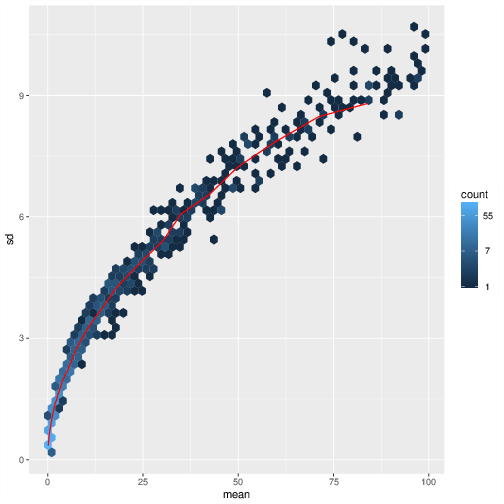

In [37]:
%preview -s png figures/mean_sd.pdf

Logarithm-transformed counts:

In [38]:
pdf("figures/mean_sd_log.pdf")
lambda <- 10^seq(from = -1, to = 2, length = 1000)
cts <- matrix(rpois(1000*100, lambda), ncol = 100)
log.cts.one <- log2(cts + 1)
vsn::meanSdPlot(log.cts.one, ranks = FALSE)
dev.off()

png 
  2

> figures/mean_sd_log.pdf (13.8 KiB):

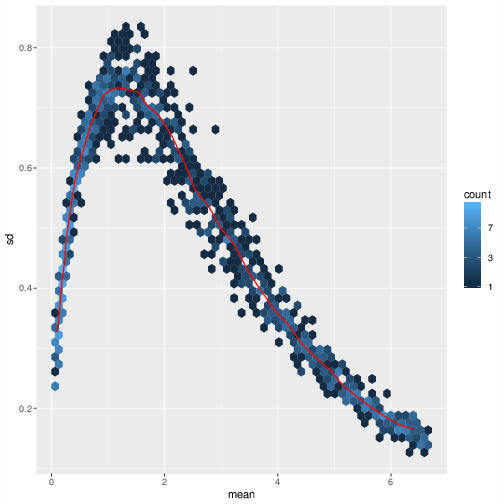

In [39]:
%preview -s png figures/mean_sd_log.pdf

The logarithm with a small pseudocount amplifies differences when the values are close to 0. The low count genes with low signal-to-noise ratio will overly contribute to sample-sample distances and PCA plots.

As a solution, DESeq2 offers two transformations for count data that stabilize the variance across the mean: the regularized-logarithm transformation or rlog (Love, Huber, and Anders 2014), and the variance stabilizing transformation (VST) for negative binomial data with a dispersion-mean trend (Anders and Huber 2010), implemented in the vst function.

For genes with high counts, the rlog and VST will give similar result to the ordinary log2 transformation of normalized counts. For genes with lower counts, however, the values are shrunken towards the genes’ averages across all samples. The rlog-transformed or VST data then becomes approximately homoskedastic, and can be used directly for computing distances between samples, making PCA plots, or as input to downstream methods which perform best with homoskedastic data.


**Which transformation to choose?** The rlog tends to work well on small datasets (n < 30), sometimes outperforming the VST when there is a large range of sequencing depth across samples (an order of magnitude difference). The VST is much faster to compute and is less sensitive to high count outliers than the rlog. We therefore recommend the VST for large datasets (hundreds of samples). You can perform both transformations and compare the meanSdPlot or PCA plots generated, as described below.

Note that the two transformations offered by DESeq2 are provided for applications other than differential testing. For differential testing we recommend the DESeq function applied to raw counts, as described later in this workflow, which also takes into account the dependence of the variance of counts on the mean value during the dispersion estimation step.

The function rlog returns an object based on the SummarizedExperiment class that contains the rlog-transformed values in its assay slot.

In [40]:
rld <- rlog(dds, blind = FALSE)
head(assay(rld), 3)

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
ENSG00000000003,9.385683,9.052608,9.516875,9.285338,9.839085,9.530311,9.663255,9.277699
ENSG00000000419,8.869616,9.138271,9.036116,9.075295,8.972126,9.131824,8.861534,9.060905
ENSG00000000457,7.961369,7.881385,7.824079,7.921490,7.751699,7.886441,7.957121,7.912123


The function *vst* returns a similar object

In [41]:
vsd <- vst(dds, blind = FALSE)
head(assay(vsd), 3)

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
ENSG00000000003,9.742340,9.430742,9.867872,9.646127,10.183344,9.880660,10.010591,9.640065
ENSG00000000419,9.334009,9.582000,9.486456,9.523397,9.427605,9.575154,9.326341,9.509553
ENSG00000000457,8.765748,8.698941,8.651978,8.732909,8.593308,8.703164,8.762420,8.724586


In the above function calls, we specified blind = FALSE, which means that differences between cell lines and treatment (the variables in the design) will not contribute to the expected variance-mean trend of the experiment. The experimental design is not used directly in the transformation, only in estimating the global amount of variability in the counts. For a fully unsupervised transformation, one can set blind = TRUE (which is the default).

To show the effect of the transformation, in the figure below we plot the first sample against the second, first simply using the log2 function (after adding 1, to avoid taking the log of zero), and then using the rlog- and VST-transformed values. For the log2 approach, we need to first estimate size factors to account for sequencing depth, and then specify normalized=TRUE. Sequencing depth correction is done automatically for the rlog and the vst.

In [42]:
pdf("figures/transformation.pdf")
suppressPackageStartupMessages(library("dplyr"))
suppressPackageStartupMessages(library("ggplot2"))

dds <- DESeq2::estimateSizeFactors(dds)

df <- bind_rows(
  as_data_frame(log2(counts(dds, normalized=TRUE)[, 1:2]+1)) %>%
         mutate(transformation = "log2(x + 1)"),
  as_data_frame(assay(rld)[, 1:2]) %>% mutate(transformation = "rlog"),
  as_data_frame(assay(vsd)[, 1:2]) %>% mutate(transformation = "vst"))
  
colnames(df)[1:2] <- c("x", "y")  

ggplot(df, aes(x = x, y = y)) + geom_hex(bins = 80) +
  coord_fixed() + facet_grid( . ~ transformation)  
dev.off()

png 
  2

> figures/transformation.pdf (47.7 KiB):

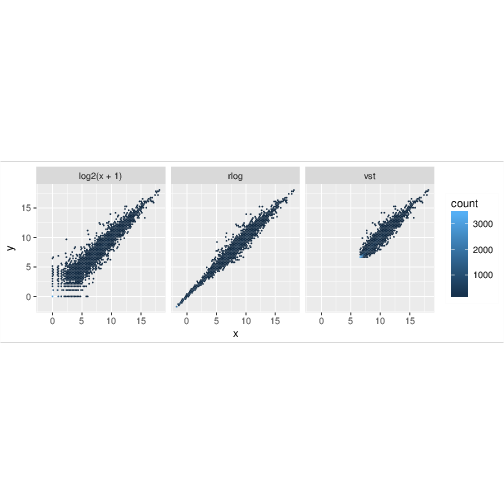

In [43]:
%preview -s png figures/transformation.pdf

**Scatterplot of transformed counts from two samples.** 
Shown are scatterplots using the log2 transform of normalized counts (left), using the rlog (middle), and using the VST (right). While the rlog is on roughly the same scale as the log2 counts, the VST has a upward shift for the smaller values. It is the differences between samples (deviation from y=x in these scatterplots) which will contribute to the distance calculations and the PCA plot.

We can see how genes with low counts (bottom left-hand corner) seem to be excessively variable on the ordinary logarithmic scale, while the rlog transform and VST compress differences for the low count genes for which the data provide little information about differential expression.

### Sample Distance

A useful first step in an RNA-seq analysis is often to assess overall similarity between samples: Which samples are similar to each other, which are different? Does this fit to the expectation from the experiment’s design?

We use the R function dist to calculate the Euclidean distance between samples. To ensure we have a roughly equal contribution from all genes, we use it on the rlog-transformed data. We need to transpose the matrix of values using t, because the dist function expects the different samples to be rows of its argument, and different dimensions (here, genes) to be columns.

In [44]:
sampleDists <- dist(t(assay(rld)))
sampleDists

           SRR1039508 SRR1039509 SRR1039512 SRR1039513 SRR1039516 SRR1039517
SRR1039509   45.69859                                                       
SRR1039512   39.25239   54.90828                                            
SRR1039513   62.63201   44.52740   48.72579                                 
SRR1039516   44.50557   59.06364   43.57856   63.74275                      
SRR1039517   64.49410   51.44882   59.22962   49.87992   47.48200           
SRR1039520   39.57693   57.46259   36.74434   58.49014   46.40786   63.59942
SRR1039521   63.36124   45.05732   57.87616   36.49484   65.54600   52.31695
           SRR1039520
SRR1039509           
SRR1039512           
SRR1039513           
SRR1039516           
SRR1039517           
SRR1039520           
SRR1039521   50.13430

We visualize the distances in a heatmap in a figure below, using the function pheatmap from the pheatmap package. In order to plot the sample distance matrix with the rows/columns arranged by the distances in our distance matrix, we manually provide sampleDists to the clustering_distance argument of the pheatmap function. Otherwise the pheatmap function would assume that the matrix contains the data values themselves, and would calculate distances between the rows/columns of the distance matrix, which is not desired. We also manually specify a blue color palette using the colorRampPalette function from the RColorBrewer package.


In [45]:
library("pheatmap")
library("RColorBrewer")
pdf("figures/dist.pdf")
## ----distheatmap, fig.width = 6.1, fig.height = 4.5----------------------
sampleDistMatrix <- as.matrix( sampleDists )
rownames(sampleDistMatrix) <- paste( rld$dex, rld$cell, sep = " - " )
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows = sampleDists,
         clustering_distance_cols = sampleDists,
         col = colors)
dev.off()

png 
  2

> figures/dist.pdf (7.3 KiB):

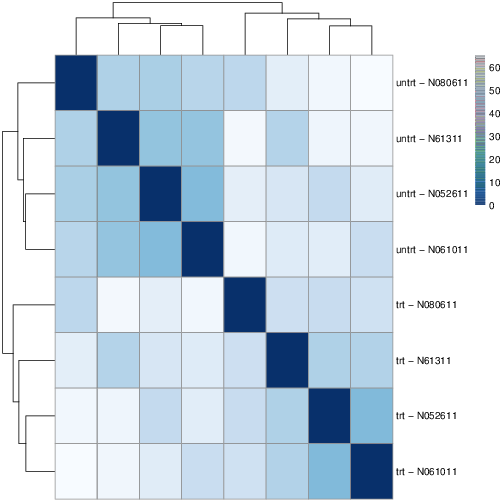

In [47]:
%preview -s png figures/dist.pdf --pages 2

**Heatmap of sample-to-sample distances using the rlog-transformed values.**

Note that we have changed the row names of the distance matrix to contain treatment type and patient number instead of sample ID, so that we have all this information in view when looking at the heatmap.


Another option for calculating sample distances is to use the Poisson Distance (Witten 2011), implemented in the PoiClaClu package. This measure of dissimilarity between counts also takes the inherent variance structure of counts into consideration when calculating the distances between samples. The PoissonDistance function takes the original count matrix (not normalized) with samples as rows instead of columns, so we need to transpose the counts in dds.

In [48]:
library("PoiClaClu")
poisd <- PoissonDistance(t(counts(dds)))
pdf("figures/dist_pois.pdf")
samplePoisDistMatrix <- as.matrix( poisd$dd )
rownames(samplePoisDistMatrix) <- paste( rld$dex, rld$cell, sep=" - " )
colnames(samplePoisDistMatrix) <- NULL
pheatmap(samplePoisDistMatrix,
         clustering_distance_rows = poisd$dd,
         clustering_distance_cols = poisd$dd,
         col = colors)
dev.off()

png 
  2

> figures/dist_pois.pdf (7.3 KiB):

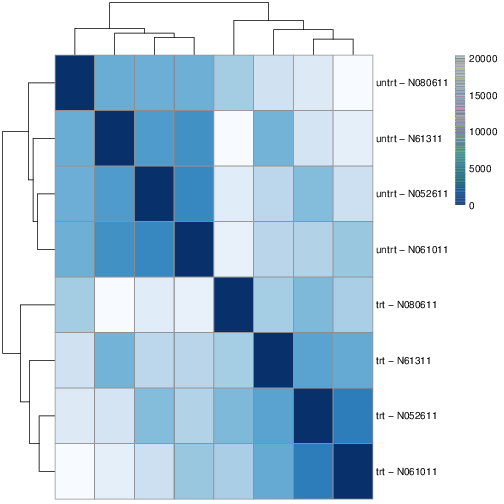

In [49]:
%preview -s png figures/dist_pois.pdf --pages 2 

**Heatmap of sample-to-sample distances using the Poisson Distance.**

### PCA plot

Another way to visualize sample-to-sample distances is a principal components analysis (PCA). In this ordination method, the data points (here, the samples) are projected onto the 2D plane such that they spread out in the two directions that explain most of the differences (figure below). The x-axis is the direction that separates the data points the most. The values of the samples in this direction are written PC1. The y-axis is a direction (it must be orthogonal to the first direction) that separates the data the second most. The values of the samples in this direction are written PC2. The percent of the total variance that is contained in the direction is printed in the axis label. Note that these percentages do not add to 100%, because there are more dimensions that contain the remaining variance (although each of these remaining dimensions will explain less than the two that we see).

Here we make PCA plot using 2 approaches: `DESeq2::plotPCA` function, and a plain `ggplot2` implementation.

In [50]:
pcaData <- DESeq2::plotPCA(rld, intgroup = c( "dex", "cell"), returnData = TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))
pdf("figures/pca.pdf")
DESeq2::plotPCA(rld, intgroup = c("dex", "cell"))
## ----ggplotpca, fig.width=6, fig.height=4.5------------------------------
ggplot(pcaData, aes(x = PC1, y = PC2, color = dex, shape = cell)) +
  geom_point(size =3) +
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC2: ", percentVar[2], "% variance")) +
  coord_fixed()
dev.off()

png 
  2

> figures/pca.pdf (6.4 KiB):

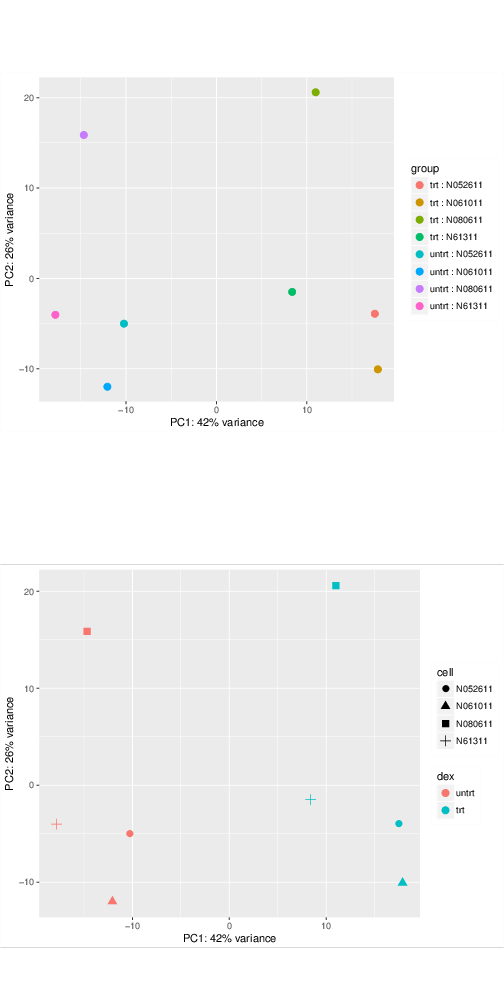

In [51]:
%preview -s png figures/pca.pdf

**PCA plot using the rlog-transformed values.** Each unique combination of treatment and cell line is given its own color.

Here, we have used the function plotPCA that comes with DESeq2. The two terms specified by intgroup are the interesting groups for labeling the samples; they tell the function to use them to choose colors. We can also build the PCA plot from scratch using the ggplot2 package (Wickham 2009). This is done by asking the plotPCA function to return the data used for plotting rather than building the plot. See the ggplot2 documentation for more details on using ggplot.

In [52]:
pcaData

,PC1,PC2,group,dex,cell,name
SRR1039508,-17.81773,-4.020836,untrt : N61311,untrt,N61311,SRR1039508
SRR1039509,8.38790,-1.490805,trt : N61311,trt,N61311,SRR1039509
SRR1039512,-10.22735,-5.004069,untrt : N052611,untrt,N052611,SRR1039512
SRR1039513,17.53277,-3.909890,trt : N052611,trt,N052611,SRR1039513
SRR1039516,-14.67169,15.873239,untrt : N080611,untrt,N080611,SRR1039516
SRR1039517,10.98782,20.598625,trt : N080611,trt,N080611,SRR1039517
SRR1039520,-12.06035,-11.985876,untrt : N061011,untrt,N061011,SRR1039520
SRR1039521,17.86863,-10.060389,trt : N061011,trt,N061011,SRR1039521


### MDS plot

Another plot, very similar to the PCA plot, can be made using the multidimensional scaling (MDS) function in base R. This is useful when we don’t have a matrix of data, but only a matrix of distances. Here we compute the MDS for the distances calculated from the rlog transformed counts and plot these in a figure below.

In [53]:
pdf("figures/mds_rlog.pdf")
mds <- as.data.frame(colData(rld))  %>%
         cbind(cmdscale(sampleDistMatrix))
ggplot(mds, aes(x = `1`, y = `2`, color = dex, shape = cell)) +
  geom_point(size = 3) + coord_fixed()
dev.off()

png 
  2

> figures/mds_rlog.pdf (5.2 KiB):

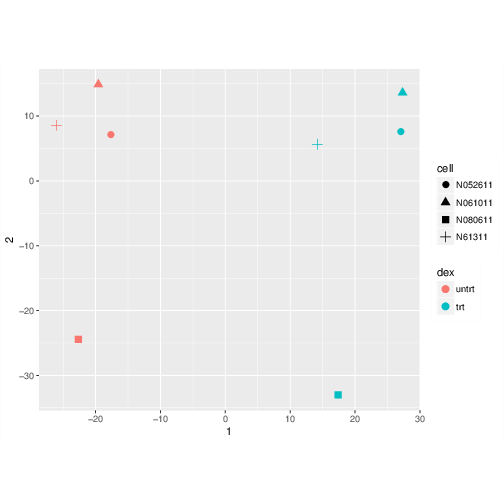

In [54]:
%preview -s png figures/mds_rlog.pdf

**MDS plot using rlog-transformed values**

In [55]:
pdf("figures/mds_pois.pdf")
mdsPois <- as.data.frame(colData(dds)) %>%
   cbind(cmdscale(samplePoisDistMatrix))
ggplot(mdsPois, aes(x = `1`, y = `2`, color = dex, shape = cell)) +
  geom_point(size = 3) + coord_fixed()
dev.off()

png 
  2

> figures/mds_pois.pdf (5.1 KiB):

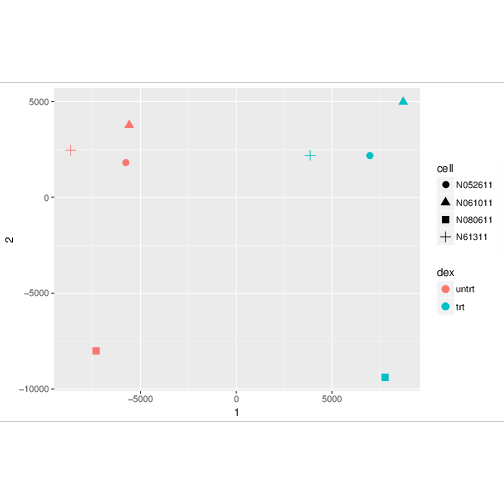

In [56]:
%preview -s png figures/mds_pois.pdf

**MDS plot using the *Poisson Distance* **

## Differentital expression analysis

### Running the differential expression pipeline

As we have already specified an experimental design when we created the DESeqDataSet, we can run the differential expression pipeline on the raw counts with a single call to the function DESeq.

In [57]:
dds <- DESeq(dds)

using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


This function will print out a message for the various steps it performs. These are described in more detail in the manual page for DESeq, which can be accessed by typing ?DESeq. Briefly these are: the estimation of size factors (controlling for differences in the sequencing depth of the samples), the estimation of dispersion values for each gene, and fitting a generalized linear model.

A DESeqDataSet is returned that contains all the fitted parameters within it, and the following section describes how to extract out results tables of interest from this object.

### Building the results table

Calling results without any arguments will extract the estimated log2 fold changes and p values for the last variable in the design formula. If there are more than 2 levels for this variable, results will extract the results table for a comparison of the last level over the first level. The comparison is printed at the top of the output: dex trt vs untrt.

In [58]:
res <- results(dds)
res

log2 fold change (MLE): dex trt vs untrt 
Wald test p-value: dex trt vs untrt 
DataFrame with 29391 rows and 6 columns
                   baseMean log2FoldChange     lfcSE        stat       pvalue
                  <numeric>      <numeric> <numeric>   <numeric>    <numeric>
ENSG00000000003 708.6021697    -0.38125388 0.1006560  -3.7876928 0.0001520527
ENSG00000000419 520.2979006     0.20681271 0.1122218   1.8428925 0.0653447023
ENSG00000000457 237.1630368     0.03792050 0.1434532   0.2643405 0.7915175170
ENSG00000000460  57.9326331    -0.08816322 0.2871677  -0.3070095 0.7588361137
ENSG00000000938   0.3180984    -1.37823397 3.4998753  -0.3937952 0.6937322727
...                     ...            ...       ...         ...          ...
ENSG00000273485   1.2864477     -0.1271363 1.6005571 -0.07943253    0.9366886
ENSG00000273486  15.4525365     -0.1509944 0.4865490 -0.31033758    0.7563043
ENSG00000273487   8.1632350      1.0464169 0.6990336  1.49694792    0.1344068
ENSG00000273488   8.584

In [59]:
mcols(res, use.names = TRUE)

DataFrame with 6 rows and 2 columns
                       type                               description
                <character>                               <character>
baseMean       intermediate mean of normalized counts for all samples
log2FoldChange      results  log2 fold change (MLE): dex trt vs untrt
lfcSE               results          standard error: dex trt vs untrt
stat                results          Wald statistic: dex trt vs untrt
pvalue              results       Wald test p-value: dex trt vs untrt
padj                results                      BH adjusted p-values

The first column, baseMean, is a just the average of the normalized count values, divided by the size factors, taken over all samples in the DESeqDataSet. The remaining four columns refer to a specific contrast, namely the comparison of the trt level over the untrt level for the factor variable dex. We will find out below how to obtain other contrasts.

The column log2FoldChange is the effect size estimate. It tells us how much the gene’s expression seems to have changed due to treatment with dexamethasone in comparison to untreated samples. This value is reported on a logarithmic scale to base 2: for example, a log2 fold change of 1.5 means that the gene’s expression is increased by a multiplicative factor of 21.5 ≈ 2.82.

Of course, this estimate has an uncertainty associated with it, which is available in the column lfcSE, the standard error estimate for the log2 fold change estimate. We can also express the uncertainty of a particular effect size estimate as the result of a statistical test. The purpose of a test for differential expression is to test whether the data provides sufficient evidence to conclude that this value is really different from zero. DESeq2 [8] performs for each gene a hypothesis test to see whether evidence is sufficient to decide against the null hypothesis that there is zero effect of the treatment on the gene and that the observed difference between treatment and control was merely caused by experimental variability (i.e., the type of variability that you can expect between different samples in the same treatment group). As usual in statistics, the result of this test is reported as a p value, and it is found in the column pvalue. Remember that a p value indicates the probability that a fold change as strong as the observed one, or even stronger, would be seen under the situation described by the null hypothesis.


We can also summarize the results with the following line of code, which reports some additional information, that will be covered in later sections.

In [60]:
summary(res)


out of 29391 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 2607, 8.9% 
LFC < 0 (down)   : 2218, 7.5% 
outliers [1]     : 0, 0% 
low counts [2]   : 11397, 39% 
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Note that there are many genes with differential expression due to dexamethasone treatment at the FDR level of 10%. This makes sense, as the smooth muscle cells of the airway are known to react to glucocorticoid steroids. However, there are two ways to be more strict about which set of genes are considered significant:

* lower the false discovery rate threshold (the threshold on padj in the results table)
* raise the log2 fold change threshold from 0 using the lfcThreshold argument of results

If we lower the false discovery rate threshold, we should also inform the results() function about it, so that the function can use this threshold for the optimal independent filtering that it performs.

In [61]:
res.05 <- results(dds, alpha = 0.05)
table(res.05$padj < 0.05)


FALSE  TRUE 
12831  4024 

If we want to raise the log2 fold change threshold, so that we test for genes that show more substantial changes due to treatment, we simply supply a value on the log2 scale. For example, by specifying lfcThreshold = 1, we test for genes that show significant effects of treatment on gene counts more than doubling or less than halving, because $2^1 = 2$.

In [62]:
resLFC1 <- results(dds, lfcThreshold=1)
table(resLFC1$padj < 0.1)


FALSE  TRUE 
20034   240 

Sometimes a subset of the p values in res will be NA (“not available”). This is DESeq’s way of reporting that all counts for this gene were zero, and hence no test was applied. In addition, p values can be assigned NA if the gene was excluded from analysis because it contained an extreme count outlier. For more information, see the outlier detection section of the DESeq2 vignette.

If you use the results from an R analysis package in published research, you can find the proper citation for the software by typing citation("pkgName"), where you would substitute the name of the package for pkgName. Citing methods papers helps to support and reward the individuals who put time into open source software for genomic data analysis.

### Other comaprisions

In general, the results for a comparison of any two levels of a variable can be extracted using the contrast argument to results. The user should specify three values: the name of the variable, the name of the level for the numerator, and the name of the level for the denominator. Here we extract results for the log2 of the fold change of one cell line over another.

In [63]:
results(dds, contrast = c("cell", "N061011", "N61311"))

log2 fold change (MLE): cell N061011 vs N61311 
Wald test p-value: cell N061011 vs N61311 
DataFrame with 29391 rows and 6 columns
                   baseMean log2FoldChange     lfcSE         stat     pvalue
                  <numeric>      <numeric> <numeric>    <numeric>  <numeric>
ENSG00000000003 708.6021697     0.30632635 0.1435330  2.134187335 0.03282745
ENSG00000000419 520.2979006    -0.05404672 0.1597205 -0.338383153 0.73507447
ENSG00000000457 237.1630368     0.01630854 0.2030380  0.080322608 0.93598068
ENSG00000000460  57.9326331     0.27912688 0.4007042  0.696590931 0.48605883
ENSG00000000938   0.3180984     0.03849337 4.9975798  0.007702403 0.99385443
...                     ...            ...       ...          ...        ...
ENSG00000273485   1.2864477    -2.32142337 2.3530918 -0.986541761  0.3238673
ENSG00000273486  15.4525365    -0.07271569 0.7119582 -0.102134773  0.9186497
ENSG00000273487   8.1632350    -0.02693764 1.0051679 -0.026799147  0.9786199
ENSG00000273488   8.58

If results for an interaction term are desired, the name argument of results should be used. Please see the help for the results function for more details.

### Multiple testing

In high-throughput biology, we are careful to not use the p values directly as evidence against the null, but to correct for multiple testing. What would happen if we were to simply threshold the p values at a low value, say 0.05? There are 5676 genes with a p value below 0.05 among the 29391 genes for which the test succeeded in reporting a p value.

In [64]:
sum(res$pvalue < 0.05, na.rm=TRUE)
sum(!is.na(res$pvalue))

[1] 5676

[1] 29391

Now, assume for a moment that the null hypothesis is true for all genes, i.e., no gene is affected by the treatment with dexamethasone. Then, by the definition of the p value, we expect up to 5% of the genes to have a p value below 0.05. This amounts to 1470 genes. If we just considered the list of genes with a p value below 0.05 as differentially expressed, this list should therefore be expected to contain up to 1470 / 5676 = 26% false positives.

DESeq2 uses the Benjamini-Hochberg (BH) adjustment (Benjamini and Hochberg 1995) as implemented in the base R p.adjust function; in brief, this method calculates for each gene an adjusted p value that answers the following question: if one called significant all genes with an adjusted p value less than or equal to this gene’s adjusted p value threshold, what would be the fraction of false positives (the false discovery rate, FDR) among them, in the sense of the calculation outlined above? These values, called the BH-adjusted p values, are given in the column padj of the res object.

The FDR is a useful statistic for many high-throughput experiments, as we are often interested in reporting or focusing on a set of interesting genes, and we would like to put an upper bound on the percent of false positives in this set.

Hence, if we consider a fraction of 10% false positives acceptable, we can consider all genes with an adjusted p value below 10% = 0.1 as significant. How many such genes are there?

In [65]:
sum(res$padj < 0.1, na.rm=TRUE)

[1] 4825

We subset the results table to these genes and then sort it by the log2 fold change estimate to get the significant genes with the strongest down-regulation.

In [66]:
resSig <- subset(res, padj < 0.1)
head(resSig[ order(resSig$log2FoldChange), ])

log2 fold change (MLE): dex trt vs untrt 
Wald test p-value: dex trt vs untrt 
DataFrame with 6 rows and 6 columns
                 baseMean log2FoldChange     lfcSE      stat       pvalue
                <numeric>      <numeric> <numeric> <numeric>    <numeric>
ENSG00000128285  6.624741      -5.325912 1.2578863 -4.234017 2.295537e-05
ENSG00000267339 26.233573      -4.611553 0.6731316 -6.850894 7.338997e-12
ENSG00000019186 14.087605      -4.325920 0.8578247 -5.042895 4.585398e-07
ENSG00000183454  5.804171      -4.264087 1.1669498 -3.654045 2.581412e-04
ENSG00000146006 46.807597      -4.211875 0.5288797 -7.963767 1.668799e-15
ENSG00000141469 53.436528      -4.124784 1.1297977 -3.650905 2.613174e-04
                        padj
                   <numeric>
ENSG00000128285 2.378002e-04
ENSG00000267339 2.053778e-10
ENSG00000019186 6.611351e-06
ENSG00000183454 2.048057e-03
ENSG00000146006 7.166675e-14
ENSG00000141469 2.069606e-03

And the strongest up-regulation:

In [67]:
head(resSig[ order(resSig$log2FoldChange, decreasing = TRUE), ])

log2 fold change (MLE): dex trt vs untrt 
Wald test p-value: dex trt vs untrt 
DataFrame with 6 rows and 6 columns
                  baseMean log2FoldChange     lfcSE      stat       pvalue
                 <numeric>      <numeric> <numeric> <numeric>    <numeric>
ENSG00000179593  67.243048       9.505972 1.0545111  9.014578 1.976299e-19
ENSG00000109906 385.071029       7.352628 0.5363902 13.707610 9.141988e-43
ENSG00000250978  56.318194       6.327393 0.6778153  9.334981 1.010098e-20
ENSG00000132518   5.654654       5.885113 1.3241367  4.444491 8.810031e-06
ENSG00000127954 286.384119       5.207160 0.4930828 10.560419 4.546302e-26
ENSG00000249364   8.839061       5.098168 1.1596852  4.396166 1.101798e-05
                        padj
                   <numeric>
ENSG00000179593 1.252166e-17
ENSG00000109906 2.253437e-40
ENSG00000250978 7.212582e-19
ENSG00000132518 1.000175e-04
ENSG00000127954 5.049763e-24
ENSG00000249364 1.223812e-04

## Plotting Results
### Counts plot

A quick way to visualize the counts for a particular gene is to use the plotCounts function that takes as arguments the DESeqDataSet, a gene name, and the group over which to plot the counts (figure below).

In [68]:
pdf("figures/top_gene.pdf")
topGene <- rownames(res)[which.min(res$padj)]
plotCounts(dds, gene = topGene, intgroup=c("dex"))
dev.off()

png 
  2

> figures/top_gene.pdf (4.6 KiB):

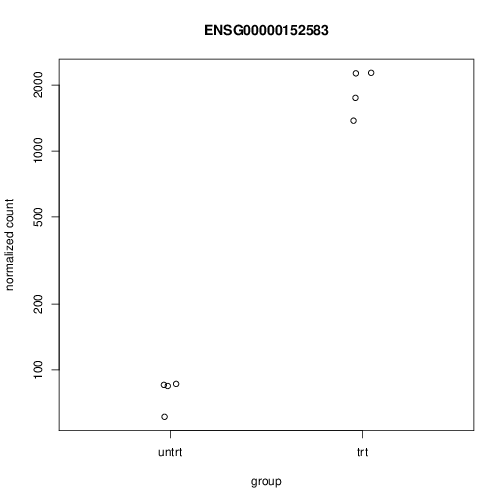

In [69]:
%preview -s png figures/top_gene.pdf

**Normalized counts for a single gene over treatment group.**

We can also make custom plots using the ggplot function from the ggplot2 package (figures below).

In [70]:
pdf("figures/counts.pdf")
library("ggbeeswarm")
geneCounts <- plotCounts(dds, gene = topGene, intgroup = c("dex","cell"),
                         returnData = TRUE)
ggplot(geneCounts, aes(x = dex, y = count, color = cell)) +
  scale_y_log10() +  geom_beeswarm(cex = 3)
## ----ggplotcountsgroup, fig.width = 4, fig.height = 3--------------------
ggplot(geneCounts, aes(x = dex, y = count, color = cell, group = cell)) +
  scale_y_log10() + geom_point(size = 3) + geom_line()
dev.off()

png 
  2

> figures/counts.pdf (5.8 KiB):

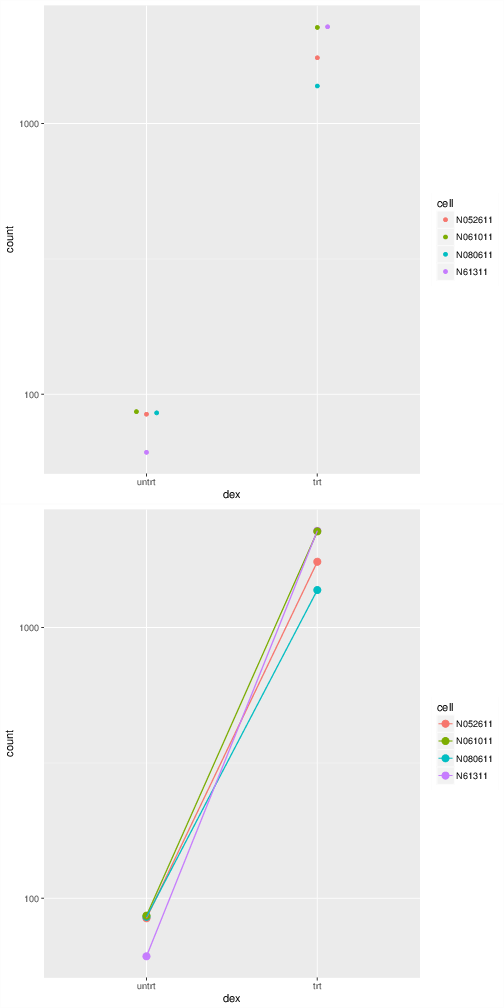

In [71]:
%preview -s png figures/counts.pdf

**Normalized counts with lines connecting cell lines.**
Note that the DESeq test actually takes into account the cell line effect, so this figure more closely depicts the difference being tested.

### MA-plot

An MA-plot (R. Dudoit et al. 2002) provides a useful overview for the distribution of the estimated coefficients in the model, e.g. the comparisons of interest, across all genes. On the y-axis, the “M” stands for “minus” – subtraction of log values is equivalent to the log of the ratio – and on the x-axis, the “A” stands for “average”. You may hear this plot also referred to as a mean-difference plot, or a Bland-Altman plot.

Before making the MA-plot, we use the lfcShrink function to shrink the log2 fold changes for the comparison of dex treated vs untreated samples:

In [72]:
pdf("figures/ma_treatment.pdf")
res <- lfcShrink(dds, contrast=c("dex","trt","untrt"), res=res)
plotMA(res, ylim = c(-5, 5))
dev.off()

png 
  2

> figures/ma_treatment.pdf (203.5 KiB):

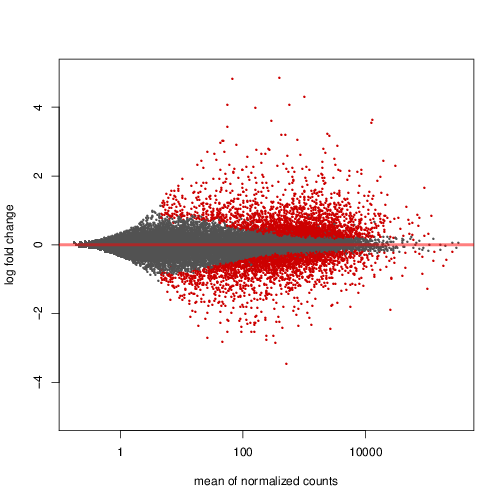

In [73]:
%preview -s png figures/ma_treatment.pdf

**An MA-plot of changes induced by treatment.** 
The log2 fold change for a particular comparison is plotted on the y-axis and the average of the counts normalized by size factor is shown on the x-axis (“M” for minus, because a log ratio is equal to log minus log, and “A” for average). Each gene is represented with a dot. Genes with an adjusted p value below a threshold (here 0.1, the default) are shown in red.

The DESeq2 package uses statistical techniques to moderate log2 fold changes from genes with very low counts and highly variable counts, as can be seen by the narrowing of the vertical spread of points on the left side of the MA-plot. For a detailed explanation of the rationale of moderated fold changes, please see the DESeq2 paper (Love, Huber, and Anders 2014). This plot demonstrates that only genes with a large average normalized count contain sufficient information to yield a significant call.

If we had not used statistical moderation to shrink the noisy log2 fold changes, we would have instead seen the following plot:


In [74]:
pdf("figures/ma_treatment_noshr.pdf")
res.noshr <- results(dds)
plotMA(res.noshr, ylim = c(-5, 5))
dev.off()

png 
  2

> figures/ma_treatment_noshr.pdf (210.5 KiB):

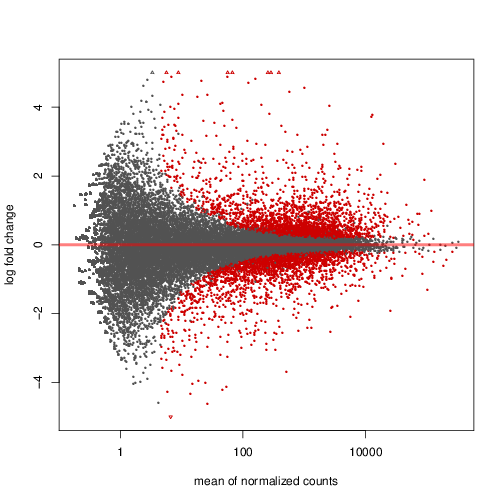

In [75]:
%preview -s png figures/ma_treatment_noshr.pdf


We can also make an MA-plot for the results table in which we raised the log2 fold change threshold (figure below). We can label individual points on the MA-plot as well. Here we use the with R function to plot a circle and text for a selected row of the results object. Within the with function, only the baseMean and log2FoldChange values for the selected rows of res are used.

In [76]:
pdf("figures/ma_log2.pdf")
plotMA(resLFC1, ylim = c(-5,5))
topGene <- rownames(resLFC1)[which.min(resLFC1$padj)]
with(resLFC1[topGene, ], {
  points(baseMean, log2FoldChange, col="dodgerblue", cex=2, lwd=2)
  text(baseMean, log2FoldChange, topGene, pos=2, col="dodgerblue")
})
dev.off()

png 
  2

> figures/ma_log2.pdf (196.9 KiB):

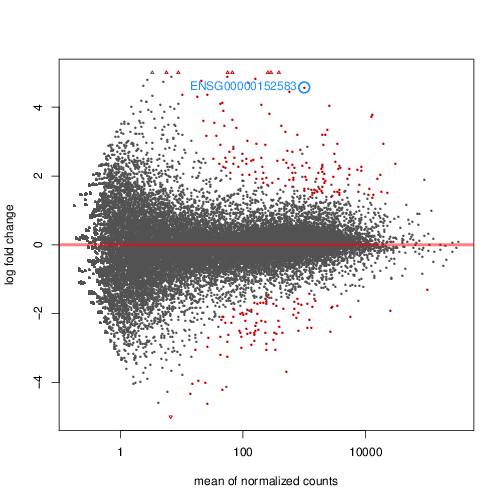

In [77]:
%preview -s png figures/ma_log2.pdf

**An MA-plot of a test for large log2 fold changes.** The red points indicate genes for which the log2 fold change was significantly higher than 1 or less than -1 (treatment resulting in more than doubling or less than halving of the normalized counts). The point circled in blue indicates the gene with the lowest adjusted p value.

Another useful diagnostic plot is the histogram of the p values (figure below). This plot is best formed by excluding genes with very small counts, which otherwise generate spikes in the histogram.

In [78]:
pdf('figures/pvals.pdf')
hist(res$pvalue[res$baseMean > 1], breaks = 0:20/20,
     col = "grey50", border = "white")
dev.off()

png 
  2

> figures/pvals.pdf (4.6 KiB):

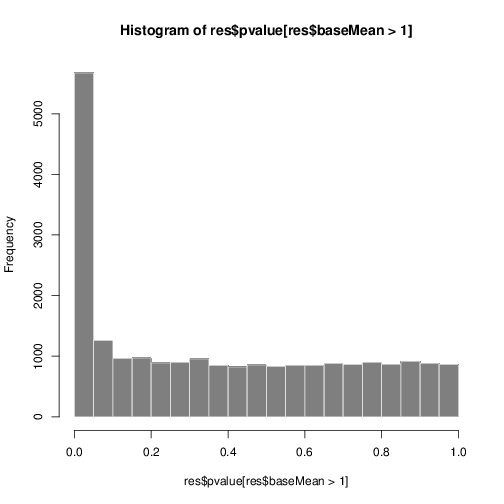

In [79]:
%preview -s png figures/pvals.pdf

**Histogram of p values for genes with mean normalized count larger than 1.**

### Gene clustering

In the sample distance heatmap made previously, the dendrogram at the side shows us a hierarchical clustering of the samples. Such a clustering can also be performed for the genes. Since the clustering is only relevant for genes that actually carry a signal, one usually would only cluster a subset of the most highly variable genes. Here, for demonstration, let us select the 20 genes with the highest variance across samples. We will work with the rlog transformed counts.

In [80]:
library("genefilter")
topVarGenes <- head(order(rowVars(assay(rld)), decreasing = TRUE), 20)


Attaching package: ‘genefilter’
The following objects are masked from ‘package:matrixStats’:

    rowSds, rowVars


The heatmap becomes more interesting if we do not look at absolute expression strength but rather at the amount by which each gene deviates in a specific sample from the gene’s average across all samples. Hence, we center each genes’ values across samples, and plot a heatmap (figure below). We provide a data.frame that instructs the pheatmap function how to label the columns.

In [81]:
pdf("figures/heatmap_rlog.pdf")
mat  <- assay(rld)[ topVarGenes, ]
mat  <- mat - rowMeans(mat)
anno <- as.data.frame(colData(rld)[, c("cell","dex")])
pheatmap(mat, annotation_col = anno)
dev.off()

png 
  2

> figures/heatmap_rlog.pdf (7.6 KiB):

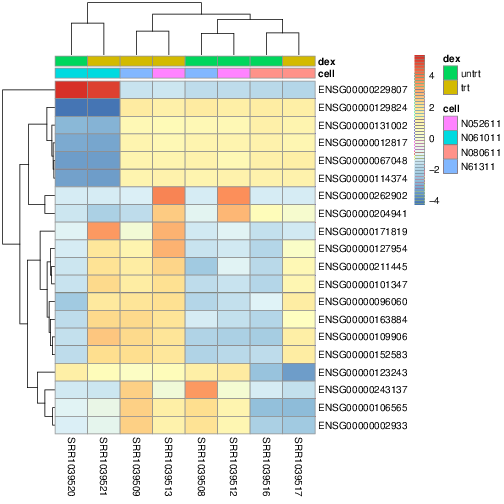

In [82]:
%preview -s png figures/heatmap_rlog.pdf --pages 2

**Heatmap of relative rlog-transformed values across samples.** 
Treatment status and cell line information are shown with colored bars at the top of the heatmap. Blocks of genes that covary across patients. Note that a set of genes at the top of the heatmap are separating the N061011 cell line from the others. In the center of the heatmap, we see a set of genes for which the dexamethasone treated samples have higher gene expression.

**Independent Filtering**

The MA plot highlights an important property of RNA-seq data. For weakly expressed genes, we have no chance of seeing differential expression, because the low read counts suffer from such high Poisson noise that any biological effect is drowned in the uncertainties from the sampling at a low rate. We can also show this by examining the ratio of small p values (say, less than 0.05) for genes binned by mean normalized count. We will use the results table subjected to the threshold to show what this looks like in a case when there are few tests with small p value.

In the following code chunk, we create bins using the quantile function, bin the genes by base mean using cut, rename the levels of the bins using the middle point, calculate the ratio of p values less than 0.05 for each bin, and finally plot these ratios (figure below).

In [83]:
pdf("figures/pval_binned.pdf")
## ----sensitivityovermean, fig.width=6------------------------------------
qs <- c(0, quantile(resLFC1$baseMean[resLFC1$baseMean > 0], 0:6/6))
bins <- cut(resLFC1$baseMean, qs)
levels(bins) <- paste0("~", round(signif((qs[-1] + qs[-length(qs)])/2, 2)))
fractionSig <- tapply(resLFC1$pvalue, bins, function(p)
                          mean(p < .05, na.rm = TRUE))
barplot(fractionSig, xlab = "mean normalized count",
                     ylab = "fraction of small p values")
dev.off()

png 
  2

> figures/pval_binned.pdf (4.3 KiB):

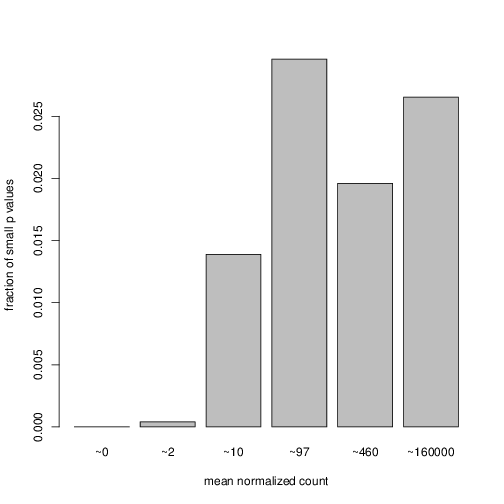

In [84]:
%preview -s png figures/pval_binned.pdf

The ratio of small p values for genes binned by mean normalized count. The p values are from a test of log2 fold change greater than 1 or less than -1. This plot demonstrates that genes with very low mean count have little or no power, and are best excluded from testing.

At first sight, there may seem to be little benefit in filtering out these genes. After all, the test found them to be non-significant anyway. However, these genes have an influence on the multiple testing adjustment, whose performance improves if such genes are removed. By removing the low count genes from the input to the FDR procedure, we can find more genes to be significant among those that we keep, and so improved the power of our test. This approach is known as independent filtering.

The DESeq2 software automatically performs independent filtering that maximizes the number of genes with adjusted p value less than a critical value (by default, alpha is set to 0.1). This automatic independent filtering is performed by, and can be controlled by, the results function.

The term independent highlights an important caveat. Such filtering is permissible only if the statistic that we filter on (here the mean of normalized counts across all samples) is independent of the actual test statistic (the p value) under the null hypothesis. Otherwise, the filtering would invalidate the test and consequently the assumptions of the BH procedure. The independent filtering software used inside DESeq2 comes from the GeneFilter package, that contains a reference to a paper describing the statistical foundation for independent filtering (Bourgon, Gentleman, and Huber 2010).

## Annotating and exporting results

Our result table so far only contains the Ensembl gene IDs, but alternative gene names may be more informative for interpretation. Bioconductor’s annotation packages help with mapping various ID schemes to each other. We load the `AnnotationDbi` package and the annotation package `org.Hs.eg.db`.

In [85]:
library("AnnotationDbi")
library("org.Hs.eg.db")

This is the organism annotation package (“org”) for Homo sapiens (“Hs”), organized as an AnnotationDbi database package (“db”), using Entrez Gene IDs (“eg”) as primary key. To get a list of all available key types:

In [86]:
columns(org.Hs.eg.db)

[1] "ACCNUM"       "ALIAS"        "ENSEMBL"      "ENSEMBLPROT"  "ENSEMBLTRANS"
 [6] "ENTREZID"     "ENZYME"       "EVIDENCE"     "EVIDENCEALL"  "GENENAME"    
[11] "GO"           "GOALL"        "IPI"          "MAP"          "OMIM"        
[16] "ONTOLOGY"     "ONTOLOGYALL"  "PATH"         "PFAM"         "PMID"        
[21] "PROSITE"      "REFSEQ"       "SYMBOL"       "UCSCKG"       "UNIGENE"     
[26] "UNIPROT"

We can use the mapIds function to add individual columns to our results table. We provide the row names of our results table as a key, and specify that keytype=ENSEMBL. The column argument tells the mapIds function which information we want, and the multiVals argument tells the function what to do if there are multiple possible values for a single input value. Here we ask to just give us back the first one that occurs in the database. To add the gene symbol and Entrez ID, we call mapIds twice.


In [87]:
res$symbol <- mapIds(org.Hs.eg.db,
                     keys=row.names(res),
                     column="SYMBOL",
                     keytype="ENSEMBL",
                     multiVals="first")
res$entrez <- mapIds(org.Hs.eg.db,
                     keys=row.names(res),
                     column="ENTREZID",
                     keytype="ENSEMBL",
                     multiVals="first")
resOrdered <- res[order(res$pvalue),]
head(resOrdered)

'select()' returned 1:many mapping between keys and columns
'select()' returned 1:many mapping between keys and columns


log2 fold change (MAP): dex trt vs untrt 
Wald test p-value: dex trt vs untrt 
DataFrame with 6 rows and 7 columns
                  baseMean log2FoldChange      stat        pvalue          padj
                 <numeric>      <numeric> <numeric>     <numeric>     <numeric>
ENSG00000152583   997.4398       4.313968  24.85607 2.223017e-136 4.000096e-132
ENSG00000165995   495.0929       3.186818  24.71198 7.951622e-135 7.154074e-131
ENSG00000120129  3409.0294       2.871488  24.27480 3.619142e-130 2.170761e-126
ENSG00000101347 12703.3871       3.618751  24.23532 9.444882e-130 4.248780e-126
ENSG00000189221  2341.7673       3.230386  23.65337 1.089779e-123 3.921897e-120
ENSG00000211445 12285.6151       3.553363  22.49579 4.563626e-112 1.368631e-108
                     symbol      entrez
                <character> <character>
ENSG00000152583     SPARCL1        8404
ENSG00000165995      CACNB2         783
ENSG00000120129       DUSP1        1843
ENSG00000101347      SAMHD1       25939
ENSG0

### Exporting results

You can easily save the results table in a CSV file that you can then share or load with a spreadsheet program such as Excel. The call to as.data.frame is necessary to convert the DataFrame object (IRanges package) to a data.frame object that can be processed by write.csv. Here, we take just the top 100 genes for demonstration.

In [88]:
resOrderedDF <- as.data.frame(resOrdered)[1:100, ]
write.csv(resOrderedDF, file = "results.csv")

A more sophisticated way for exporting results the Bioconductor package ReportingTools (Huntley et al. 2013). ReportingTools will automatically generate dynamic HTML documents, including links to external databases using gene identifiers and boxplots summarizing the normalized counts across groups. See the ReportingTools vignettes for full details. The simplest version of creating a dynamic ReportingTools report is performed with the following code.

In [91]:
library("ReportingTools")
htmlRep <- HTMLReport(shortName="report", title="My report",
                      reportDirectory="figures")
publish(resOrderedDF, htmlRep)
url <- finish(htmlRep)

In [92]:
%preview figures/report.html

> report/report.html (20.5 KiB):

baseMean,log2FoldChange,stat,pvalue,padj,symbol,entrez
baseMean,log2FoldChange,stat,pvalue,padj,symbol,entrez
997,4.310,24.9,2.22e-136,4.00e-132,SPARCL1,8404
495,3.190,24.7,7.95e-135,7.15e-131,CACNB2,783
3410,2.870,24.3,3.62e-130,2.17e-126,DUSP1,1843
12700,3.620,24.2,9.44e-130,4.25e-126,SAMHD1,25939
2340,3.230,23.7,1.09e-123,3.92e-120,MAOA,4128
12300,3.550,22.5,4.56e-112,1.37e-108,GPX3,2878
3010,1.950,22.0,5.69e-107,1.46e-103,STEAP2,261729
5390,2.000,21.6,1.30e-103,2.93e-100,NEXN,91624
3660,2.170,20.9,2.87e-97,5.74e-94,MT2A,4502


### Plotting fold changes in genomic space

If we have used the summarizeOverlaps function to count the reads, then our DESeqDataSet object is built on top of ready-to-use Bioconductor objects specifying the genomic coordinates of the genes. We can therefore easily plot our differential expression results in genomic space. While the results function by default returns a DataFrame, using the format argument, we can ask for GRanges or GRangesList output.

In [93]:
resGR <- results(dds, lfcThreshold = 1, format = "GRanges")
resGR

rowRanges is GRangesList, performing unlist(range(x)) on the rowRanges


GRanges object with 29391 ranges and 6 metadata columns:
                  seqnames                 ranges strand |          baseMean
                     <Rle>              <IRanges>  <Rle> |         <numeric>
  ENSG00000000003        X [ 99883667,  99894988]      - |  708.602169691234
  ENSG00000000419       20 [ 49551404,  49575092]      - |  520.297900552084
  ENSG00000000457        1 [169818772, 169863408]      - |  237.163036796015
  ENSG00000000460        1 [169631245, 169823221]      + |  57.9326331250967
  ENSG00000000938        1 [ 27938575,  27961788]      - | 0.318098378392895
              ...      ...                    ...    ... .               ...
  ENSG00000273485       10 [105209953, 105210609]      + |  1.28644765243289
  ENSG00000273486        3 [136556180, 136557863]      - |  15.4525365439045
  ENSG00000273487        1 [ 92654794,  92656264]      + |   8.1632349843654
  ENSG00000273488        3 [100080031, 100080481]      + |  8.58447903624707
  ENSG00000273489  

We need to add the symbol again for labeling the genes on the plot:

In [94]:
resGR$symbol <- mapIds(org.Hs.eg.db, names(resGR), "SYMBOL", "ENSEMBL")

'select()' returned 1:many mapping between keys and columns


We will use the Gviz package for plotting the GRanges and associated metadata: the log fold changes due to dexamethasone treatment.

In [95]:
suppressPackageStartupMessages(library("Gviz"))

The following code chunk specifies a window of 1 million base pairs upstream and downstream from the gene with the smallest p value. We create a subset of our full results, for genes within the window. We add the gene symbol as a name if the symbol exists and is not duplicated in our subset.

In [96]:
window <- resGR[topGene] + 1e6
strand(window) <- "*"

resGRsub <- resGR[resGR %over% window]
naOrDup <- is.na(resGRsub$symbol) | duplicated(resGRsub$symbol)
resGRsub$group <- ifelse(naOrDup, names(resGRsub), resGRsub$symbol)

We create a vector specifying if the genes in this subset had a low value of `padj`.

In [97]:
status <- factor(ifelse(resGRsub$padj < 0.1 & !is.na(resGRsub$padj),
                     "sig", "notsig"))

We can then plot the results using Gviz functions (figure below). We create an axis track specifying our location in the genome, a track that will show the genes and their names, colored by significance, and a data track that will draw vertical bars showing the moderated log fold change produced by DESeq2, which we know are only large when the effect is well supported by the information in the counts.

In [98]:
pdf("figures/gviz_genes.pdf")
## ----gvizplot------------------------------------------------------------
options(ucscChromosomeNames = FALSE)
g <- GenomeAxisTrack()
a <- AnnotationTrack(resGRsub, name = "gene ranges", feature = status)
d <- DataTrack(resGRsub, data = "log2FoldChange", baseline = 0,
               type = "h", name = "log2 fold change", strand = "+")
plotTracks(list(g, d, a), groupAnnotation = "group",
           notsig = "grey", sig = "hotpink")
dev.off()

png 
  2

> figures/gviz_genes.pdf (6.5 KiB):

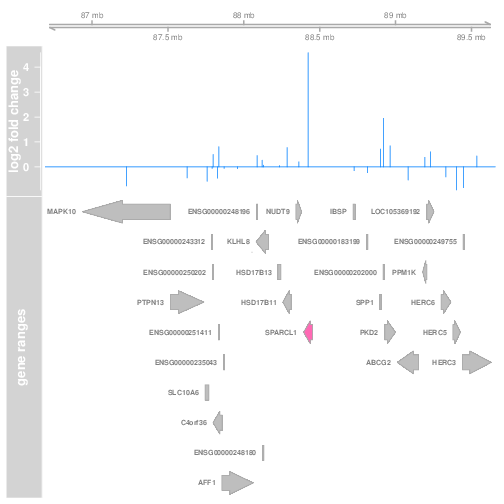

In [99]:
%preview -s png figures/gviz_genes.pdf

**log2 fold changes in genomic region surrounding the gene with smallest adjusted p value.** 
Genes highlighted in pink have adjusted p value less than 0.1.

## Removing hidden batch effects

Suppose we did not know that there were different cell lines involved in the experiment, only that there was treatment with dexamethasone. The cell line effect on the counts then would represent some hidden and unwanted variation that might be affecting many or all of the genes in the dataset. We can use statistical methods designed for RNA-seq from the SVA package (Leek 2014) to detect such groupings of the samples, and then we can add these to the DESeqDataSet design, in order to account for them. The SVA package uses the term surrogate variables for the estimated variables that we want to account for in our analysis. Another package for detecting hidden batches is the RUVSeq package (Risso et al. 2014), with the acronym “Remove Unwanted Variation”.

Below we obtain a matrix of normalized counts for which the average count across samples is larger than 1. As we described above, we are trying to recover any hidden batch effects, supposing that we do not know the cell line information. So we use a full model matrix with the dex variable, and a reduced, or null, model matrix with only an intercept term. Finally we specify that we want to estimate 2 surrogate variables. For more information read the manual page for the sva-seq function by typing *?svaseq*.

In [100]:
suppressPackageStartupMessages(library("sva"))
dat  <- counts(dds, normalized = TRUE)
idx  <- rowMeans(dat) > 1
dat  <- dat[idx, ]
mod  <- model.matrix(~ dex, colData(dds))
mod0 <- model.matrix(~   1, colData(dds))
svseq <- svaseq(dat, mod, mod0, n.sv = 2)

Number of significant surrogate variables is:  2 
Iteration (out of 5 ):1  2  3  4  5  

In [101]:
svseq$sv

0.2481108,-0.52600157
0.2629867,-0.58115433
0.1502704,0.27428267
0.2023800,0.38419545
-0.6086586,-0.07854931
-0.6101210,-0.02923693
0.1788509,0.25708985
0.1761807,0.29937417


Because we actually do know the cell lines, we can see how well the SVA method did at recovering these variables (figure below).

In [102]:
pdf("figures/sva.pdf")
par(mfrow = c(2, 1), mar = c(3,5,3,1))
for (i in 1:2) {
  stripchart(svseq$sv[, i] ~ dds$cell, vertical = TRUE, main = paste0("SV", i))
  abline(h = 0)
 }
dev.off()

png 
  2

> figures/sva.pdf (4.7 KiB):

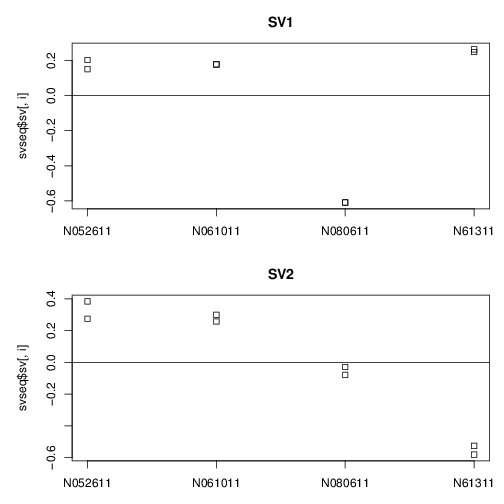

In [103]:
%preview -s png figures/sva.pdf

**Surrogate variables 1 and 2 plotted over cell line.** 
Here, we know the hidden source of variation (cell line), and therefore can see how the SVA procedure is able to identify a source of variation which is correlated with cell line.

Finally, in order to use SVA to remove any effect on the counts from our surrogate variables, we simply add these two surrogate variables as columns to the DESeqDataSet and then add them to the design.

In [104]:
ddssva <- dds
ddssva$SV1 <- svseq$sv[,1]
ddssva$SV2 <- svseq$sv[,2]
design(ddssva) <- ~ SV1 + SV2 + dex

We could then produce results controlling for surrogate variables by running DESeq with the new design.

In [105]:
library("magrittr")
ddssva %<>% DESeq

using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


## Time course experiments

DESeq2 can be used to analyze time course experiments, for example to find those genes that react in a condition-specific manner over time, compared to a set of baseline samples. Here we demonstrate a basic time course analysis with the `fission` data package, which contains gene counts for an RNA-seq time course of `fission` yeast (Leong et al. 2014). The yeast were exposed to oxidative stress, and half of the samples contained a deletion of the gene atf21. We use a design formula that models the strain difference at time 0, the difference over time, and any strain-specific differences over time (the interaction term strain:minute).

In [106]:
library("fission")
data("fission")
ddsTC <- DESeqDataSet(fission, ~ strain + minute + strain:minute)

The following chunk of code performs a likelihood ratio test for differential analysis, where we remove the strain-specific differences over time. Genes with small p values from this test are those which at one or more time points after time 0 showed a strain-specific effect. Note therefore that this will not give small p values to genes that moved up or down over time in the same way in both strains.

In [107]:
ddsTC <- DESeq(ddsTC, test="LRT", reduced = ~ strain + minute)
resTC <- results(ddsTC)
resTC$symbol <- mcols(ddsTC)$symbol

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [108]:
head(resTC[order(resTC$padj),], 4)

log2 fold change (MLE): strainmut.minute180 
LRT p-value: '~ strain + minute + strain:minute' vs '~ strain + minute' 
DataFrame with 4 rows and 7 columns
              baseMean log2FoldChange     lfcSE      stat       pvalue
             <numeric>      <numeric> <numeric> <numeric>    <numeric>
SPBC2F12.09c  174.6712    -2.65671953 0.7522613  97.28339 1.974151e-19
SPAC1002.18   444.5050    -0.05093214 0.2042995  56.95360 5.169552e-11
SPAC1002.19   336.3732    -0.39274898 0.5734940  43.53391 2.879804e-08
SPAC1002.17c  261.7731    -1.13876477 0.6061288  39.31584 2.051371e-07
                     padj      symbol
                <numeric> <character>
SPBC2F12.09c 1.334526e-15       atf21
SPAC1002.18  1.747308e-07        urg3
SPAC1002.19  6.489157e-05        urg1
SPAC1002.17c 3.466817e-04        urg2

This is just one of the tests that can be applied to time series data. Another option would be to model the counts as a smooth function of time, and to include an interaction term of the condition with the smooth function. It is possible to build such a model using spline basis functions within R, and another, more modern approach is using Gaussian processes (Tonner et al. 2017).

We can plot the counts for the groups over time using ggplot2, for the gene with the smallest adjusted p value, testing for condition-dependent time profile and accounting for differences at time 0 (figure below). Keep in mind that the interaction terms are the difference between the two groups at a given time after accounting for the difference at time 0.

In [109]:
pdf("figures/fission_counts.pdf")
fiss <- plotCounts(ddsTC, which.min(resTC$padj), 
                   intgroup = c("minute","strain"), returnData = TRUE)
ggplot(fiss,
  aes(x = as.numeric(minute), y = count, color = strain, group = strain)) + 
  geom_point() + geom_smooth(se = FALSE, method = "loess") + scale_y_log10()
dev.off()

png 
  2

> figures/fission_counts.pdf (6.0 KiB):

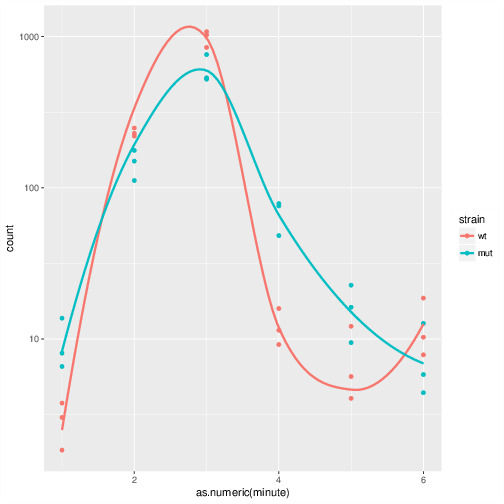

In [110]:
%preview -s png figures/fission_counts.pdf

**Normalized counts for a gene with condition-specific changes over time.**

Wald tests for the log2 fold changes at individual time points can be investigated using the test argument to results.

In [111]:
resultsNames(ddsTC)
res30 <- results(ddsTC, name="strainmut.minute30", test="Wald")

[1] "Intercept"           "strain_mut_vs_wt"    "minute_15_vs_0"     
 [4] "minute_30_vs_0"      "minute_60_vs_0"      "minute_120_vs_0"    
 [7] "minute_180_vs_0"     "strainmut.minute15"  "strainmut.minute30" 
[10] "strainmut.minute60"  "strainmut.minute120" "strainmut.minute180"

In [112]:
res30[which.min(resTC$padj),]

log2 fold change (MLE): strainmut.minute30 
Wald test p-value: strainmut.minute30 
DataFrame with 1 row and 6 columns
              baseMean log2FoldChange     lfcSE      stat       pvalue
             <numeric>      <numeric> <numeric> <numeric>    <numeric>
SPBC2F12.09c  174.6712      -2.600469 0.6343429 -4.099469 4.140994e-05
                  padj
             <numeric>
SPBC2F12.09c 0.2799312

We can furthermore cluster significant genes by their profiles. We extract a matrix of the shrunken log2 fold changes using the coef function.

In [113]:
betas <- coef(ddsTC)
colnames(betas)

[1] "Intercept"           "strain_mut_vs_wt"    "minute_15_vs_0"     
 [4] "minute_30_vs_0"      "minute_60_vs_0"      "minute_120_vs_0"    
 [7] "minute_180_vs_0"     "strainmut.minute15"  "strainmut.minute30" 
[10] "strainmut.minute60"  "strainmut.minute120" "strainmut.minute180"

We can now plot the log2 fold changes in a heatmap (figure below).

In [114]:
pdf("figures/fission_heatmap.pdf")
topGenes <- head(order(resTC$padj),20)
mat <- betas[topGenes, -c(1,2)]
thr <- 3 
mat[mat < -thr] <- -thr
mat[mat > thr] <- thr
pheatmap(mat, breaks=seq(from=-thr, to=thr, length=101),
         cluster_col=FALSE)
dev.off()

Found more than one class "unit" in cache; using the first, from namespace 'hexbin'
Also defined by 'ggbio'
Found more than one class "unit" in cache; using the first, from namespace 'hexbin'
Also defined by 'ggbio'
Found more than one class "unit" in cache; using the first, from namespace 'hexbin'
Also defined by 'ggbio'
Found more than one class "unit" in cache; using the first, from namespace 'hexbin'
Also defined by 'ggbio'


png 
  2

> figures/fission_heatmap.pdf (7.4 KiB):

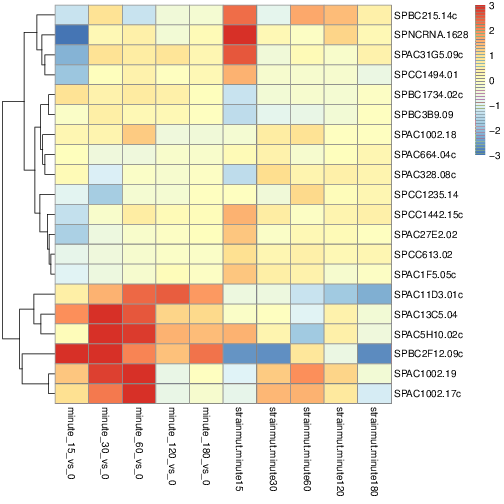

In [115]:
%preview -s png figures/fission_heatmap.pdf --pages 2

**Heatmap of log2 fold changes for genes with smallest adjusted p value.**

The bottom set of genes show strong induction of expression for the baseline samples in minutes 15-60 (red boxes in the bottom left corner), but then have slight differences for the mutant strain (shown in the boxes in the bottom right corner).

## Session Information

Similar to R's `sessionInfo()` function, SoS notebook has a `%sessioninfo` magic that documents the languages and version of packages it uses.

In [116]:
%sessioninfo

SoS Version,0.9.9.1
Kernel,ir
Language,R


## Reference
Anders, Simon, and Wolfgang Huber. 2010. “Differential expression analysis for sequence count data.” Genome Biology 11 (10): R106+. doi:10.1186/gb-2010-11-10-r106.

Anders, Simon, Paul T. Pyl, and Wolfgang Huber. 2015. “HTSeq – a Python framework to work with high-throughput sequencing data.” Bioinformatics 31 (2): 166–69. doi:10.1093/bioinformatics/btu638.

Benjamini, Yoav, and Yosef Hochberg. 1995. “Controlling the False Discovery Rate: A Practical and Powerful Approach to Multiple Testing.” Journal of the Royal Statistical Society. Series B (Methodological) 57 (1): 289–300. http://www.jstor.org/stable/2346101.

Bourgon, R., R. Gentleman, and W. Huber. 2010. “Independent filtering increases detection power for high-throughput experiments.” Proceedings of the National Academy of Sciences 107 (21): 9546–51. doi:10.1073/pnas.0914005107.

Bray, Nicolas, Harold Pimentel, Pall Melsted, and Lior Pachter. 2016. “Near-Optimal Probabilistic Rna-Seq Quantification.” Nature Biotechnology 34: 525–27. http://dx.doi.org/10.1038/nbt.3519.

Dobin, Alexander, Carrie A. Davis, Felix Schlesinger, Jorg Drenkow, Chris Zaleski, Sonali Jha, Philippe Batut, Mark Chaisson, and Thomas R. Gingeras. 2013. “STAR: ultrafast universal RNA-seq aligner.” Bioinformatics 29 (1): 15–21. doi:10.1093/bioinformatics/bts635.

Dudoit, Rine, Yee H. Yang, Matthew J. Callow, and Terence P. Speed. 2002. “Statistical methods for identifying differentially expressed genes in replicated cDNA microarray experiments.” Statistica Sinica, 111–39.

Flicek, Paul, M. Ridwan Amode, Daniel Barrell, Kathryn Beal, Konstantinos Billis, Simon Brent, Denise Carvalho-Silva, et al. 2014. “Ensembl 2014.” Nucleic Acids Research 42 (D1): D749–D755. doi:10.1093/nar/gkt1196.

Hardcastle, Thomas, and Krystyna Kelly. 2010. “baySeq: Empirical Bayesian methods for identifying differential expression in sequence count data.” BMC Bioinformatics 11 (1): 422+. doi:10.1186/1471-2105-11-422.

Himes, Blanca E., Xiaofeng Jiang, Peter Wagner, Ruoxi Hu, Qiyu Wang, Barbara Klanderman, Reid M. Whitaker, et al. 2014. “RNA-Seq transcriptome profiling identifies CRISPLD2 as a glucocorticoid responsive gene that modulates cytokine function in airway smooth muscle cells.” PloS One 9 (6). doi:10.1371/journal.pone.0099625.

Huber, Wolfgang, Vincent J. Carey, Robert Gentleman, Simon Anders, Marc Carlson, Benilton S. Carvalho, Hector Corrada C. Bravo, et al. 2015. “Orchestrating high-throughput genomic analysis with Bioconductor.” Nature Methods 12 (2). Nature Publishing Group: 115–21. doi:10.1038/nmeth.3252.

Huntley, Melanie A., Jessica L. Larson, Christina Chaivorapol, Gabriel Becker, Michael Lawrence, Jason A. Hackney, and Joshua S. Kaminker. 2013. “ReportingTools: an automated result processing and presentation toolkit for high-throughput genomic analyses.” Bioinformatics 29 (24). Oxford University Press: 3220–1. doi:10.1093/bioinformatics/btt551.

Kent, W. James, Charles W. Sugnet, Terrence S. Furey, Krishna M. Roskin, Tom H. Pringle, Alan M. Zahler, and David Haussler. 2002. “The human genome browser at UCSC.” Genome Research 12 (6). Cold Spring Harbor Laboratory Press: 996–1006. doi:10.1101/gr.229102.

Law, Charity W., Yunshun Chen, Wei Shi, and Gordon K. Smyth. 2014. “Voom: precision weights unlock linear model analysis tools for RNA-seq read counts.” Genome Biology 15 (2). BioMed Central Ltd: R29+. doi:10.1186/gb-2014-15-2-r29.

Lawrence, Michael, Wolfgang Huber, Hervé Pagès, Patrick Aboyoun, Marc Carlson, Robert Gentleman, Martin T. Morgan, and Vincent J. Carey. 2013. “Software for Computing and Annotating Genomic Ranges.” Edited by Andreas Prlic. PLoS Computational Biology 9 (8). Public Library of Science: e1003118+. doi:10.1371/journal.pcbi.1003118.

Leek, Jeffrey T. 2014. “svaseq: removing batch effects and other unwanted noise from sequencing data.” Nucleic Acids Research 42 (21). Oxford University Press: 000. doi:10.1093/nar/gku864.

Leng, N., J. A. Dawson, J. A. Thomson, V. Ruotti, A. I. Rissman, B. M. G. Smits, J. D. Haag, M. N. Gould, R. M. Stewart, and C. Kendziorski. 2013. “EBSeq: an empirical Bayes hierarchical model for inference in RNA-seq experiments.” Bioinformatics 29 (8). Oxford University Press: 1035–43. doi:10.1093/bioinformatics/btt087.

Leong, Hui S., Keren Dawson, Chris Wirth, Yaoyong Li, Yvonne Connolly, Duncan L. Smith, Caroline R. Wilkinson, and Crispin J. Miller. 2014. “A global non-coding RNA system modulates fission yeast protein levels in response to stress.” Nature Communications 5. doi:10.1038/ncomms4947.

Li, Bo, and Colin N. Dewey. 2011. “RSEM: accurate transcript quantification from RNA-Seq data with or without a reference genome.” BMC Bioinformatics 12: 323+. doi:10.1186/1471-2105-12-3231.

Li, Heng, Bob Handsaker, Alec Wysoker, Tim Fennell, Jue Ruan, Nils Homer, Gabor Marth, Goncalo Abecasis, Richard Durbin, and 1000 Genome Project Data Processing Subgroup. 2009. “The Sequence Alignment/Map format and SAMtools.” Bioinformatics (Oxford, England) 25 (16). Oxford University Press: 2078–9. doi:10.1093/bioinformatics/btp352.

Liao, Y., G. K. Smyth, and W. Shi. 2014. “featureCounts: an efficient general purpose program for assigning sequence reads to genomic features.” Bioinformatics 30 (7). Oxford University Press: 923–30. doi:10.1093/bioinformatics/btt656.

Love, Michael I., John B. Hogenesch, and Rafael A. Irizarry. 2016. “Modeling of Rna-Seq Fragment Sequence Bias Reduces Systematic Errors in Transcript Abundance Estimation.” Nature Biotechnology 34 (12): 1287–91. http://dx.doi.org/10.1038/nbt.3682.

Love, Michael I., Wolfgang Huber, and Simon Anders. 2014. “Moderated estimation of fold change and dispersion for RNA-seq data with DESeq2.” Genome Biology 15 (12). BioMed Central Ltd: 550+. doi:10.1186/s13059-014-0550-8.

Patro, Rob, Geet Duggal, Michael I. Love, Rafael A. Irizarry, and Carl Kingsford. 2017. “Salmon Provides Fast and Bias-Aware Quantification of Transcript Expression.” Nature Methods 14 (4): 417–19. http://dx.doi.org/10.1038/nmeth.4197.

Patro, Rob, Stephen M. Mount, and Carl Kingsford. 2014. “Sailfish enables alignment-free isoform quantification from RNA-seq reads using lightweight algorithms.” Nature Biotechnology 32: 462–64. doi:10.1038/nbt.2862.

Risso, Davide, John Ngai, Terence P. Speed, and Sandrine Dudoit. 2014. “Normalization of RNA-seq data using factor analysis of control genes or samples.” Nature Biotechnology 32 (9). Nature Publishing Group: 896–902. doi:10.1038/nbt.2931.

Robert, Christelle, and Mick Watson. 2015. “Errors in RNA-Seq quantification affect genes of relevance to human disease.” Genome Biology. doi:10.1186/s13059-015-0734-x.

Robinson, M. D., D. J. McCarthy, and G. K. Smyth. 2009. “edgeR: a Bioconductor package for differential expression analysis of digital gene expression data.” Bioinformatics 26 (1). Oxford University Press: 139–40. doi:10.1093/bioinformatics/btp616.

Schurch, Nicholas J., Pieta Schofield, Marek Gierlinski, Christian Cole, Alexander Sherstnev, Vijender Singh, Nicola Wrobel, et al. 2016. “How Many Biological Replicates Are Needed in an Rna-Seq Experiment and Which Differential Expression Tool Should You Use?” 22 (6): 839–51. doi:10.1261/rna.053959.115.

Soneson, Charlotte, Michael I. Love, and Mark Robinson. 2015. “Differential analyses for RNA-seq: transcript-level estimates improve gene-level inferences.” F1000Research 4 (1521). doi:10.12688/f1000research.7563.1.

Tonner, Peter D, Cynthia L Darnell, Barbara E Engelhardt, and Amy K Schmid. 2017. “Detecting differential growth of microbial populations with Gaussian process regression.” Genome Research 27: 320–33. doi:10.1101/gr.210286.116.

Trapnell, Cole, David G Hendrickson, Martin Sauvageau, Loyal Goff, John L Rinn, and Lior Pachter. 2013. “Differential analysis of gene regulation at transcript resolution with RNA-seq.” Nature Biotechnology. doi:10.1038/nbt.2450.

Wickham, Hadley. 2009. ggplot2. New York, NY: Springer New York. doi:10.1007/978-0-387-98141-3.

Witten, Daniela M. 2011. “Classification and clustering of sequencing data using a Poisson model.” The Annals of Applied Statistics 5 (4): 2493–2518. doi:10.1214/11-AOAS493.

Wu, Hao, Chi Wang, and Zhijin Wu. 2013. “A new shrinkage estimator for dispersion improves differential expression detection in RNA-seq data.” Biostatistics 14 (2). Oxford University Press: 232–43. doi:10.1093/biostatistics/kxs033.

